## Import Python Package

In [ ]:
!pip install rdkit
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, rdMolDescriptors, rdFingerprintGenerator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 48.2 MB/s eta 0:00:00


## Import 'processed_DrugSolubilityData.csv' and 'compound' data files as Pandas Dataframes

In [ ]:
# import 'processed_DrugSolubilityData.csv' file
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vR6vel81WrzQdxMc7Gp1bH0zZVIYvne2VUUnwOOJn-gHPx-l0cm4cry4J3iWu0qUA/pub?gid=2051224698&single=true&output=csv"
df = pd.read_csv(url)

# Import the "compound.csv" file
url_compound = "https://docs.google.com/spreadsheets/d/e/2PACX-1vShVW7aUkUq3MLQ-dYWJWjePYSXf3CtVdPBC4ddiw-3HPbnY1s6BQ8O9ualjgJKEg/pub?gid=1310793638&single=true&output=csv"
df_compound = pd.read_csv(url_compound)

## 0.1 Check Dataset Structure and Information

In [ ]:
# Check structure of processed solubility data - Data file for solubility, solvent, solute data
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27166 entries, 0 to 27165
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   value                       27166 non-null  float64
 1   Temperature, K              27166 non-null  float64
 2   property                    27166 non-null  object 
 3   unit                        27166 non-null  object 
 4   cmp_ids_solvent             27166 non-null  object 
 5   cmp_mole_fractions_solvent  27166 non-null  object 
 6   cmp_ids_drug                27166 non-null  object 
 7   cmp_mole_fractions_drug     27166 non-null  object 
dtypes: float64(2), object(6)
memory usage: 1.7+ MB


,value,"Temperature, K"
count,27166.000000,27166.000000
mean,0.224199,301.990418
std,1.044410,14.798865
min,-5.476500,252.550000
25%,-0.418575,288.150000
50%,0.374350,303.150000
75%,1.013475,313.150000
max,1.993800,368.150000


In [ ]:
# Check structure of compound - Data file for compound ids and names
df_compound.info()
df_compound.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   compound_id  169 non-null    int64 
 1   name         169 non-null    object
 2   smiles       169 non-null    object
 3   salt         169 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 5.4+ KB


,compound_id,salt
count,169.000000,169.000000
mean,84.000000,0.106509
std,48.930222,0.309405
min,0.000000,0.000000
25%,42.000000,0.000000
50%,84.000000,0.000000
75%,126.000000,0.000000
max,168.000000,1.000000


## 0.2 Check for Missing Data and Outliers in df and df_compound

In [ ]:
# Check missing data in df and df_compound
print(f'Missing Data in df: \n{df.isnull().sum()}\n')
print(f'Missing Data in df_compound: \n{df_compound.isnull().sum()}')

# Check duplicates in df and df_compound
duplicates = df[df.duplicated()]
print(f'\nDuplicates in df:\n{duplicates}')

duplicates_compound = df_compound[df_compound.duplicated()]
print(f'\nDuplicates in df_compound:\n{duplicates_compound}')

# Results show that no missing data or duplicate rows in df and df_compound

Missing Data in df: 
value                         0
Temperature, K                0
property                      0
unit                          0
cmp_ids_solvent               0
cmp_mole_fractions_solvent    0
cmp_ids_drug                  0
cmp_mole_fractions_drug       0
dtype: int64

Missing Data in df_compound: 
compound_id    0
name           0
smiles         0
salt           0
dtype: int64

Duplicates in df:
Empty DataFrame
Columns: [value, Temperature, K, property, unit, cmp_ids_solvent, cmp_mole_fractions_solvent, cmp_ids_drug, cmp_mole_fractions_drug]
Index: []

Duplicates in df_compound:
Empty DataFrame
Columns: [compound_id, name, smiles, salt]
Index: []


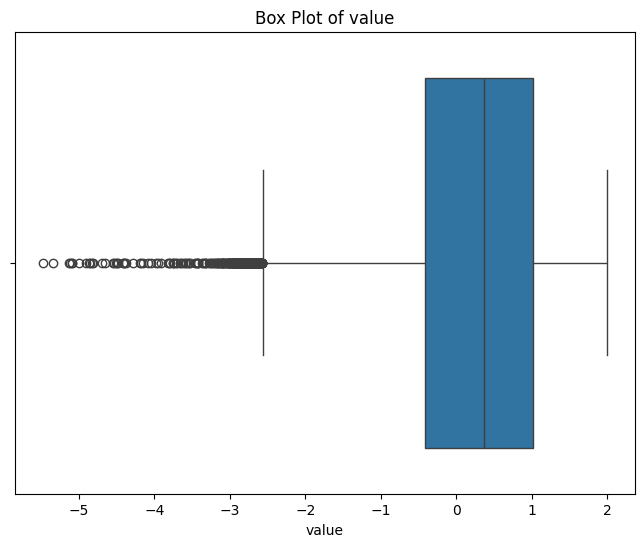

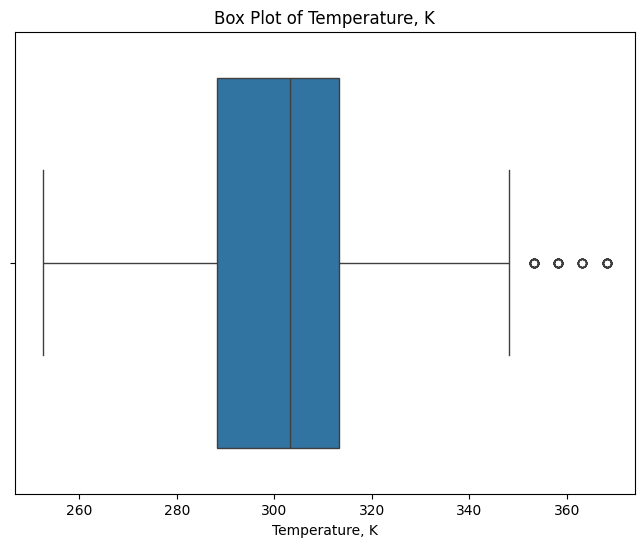

In [ ]:
# Check for outliers in df using box plots for numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns

for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.show()

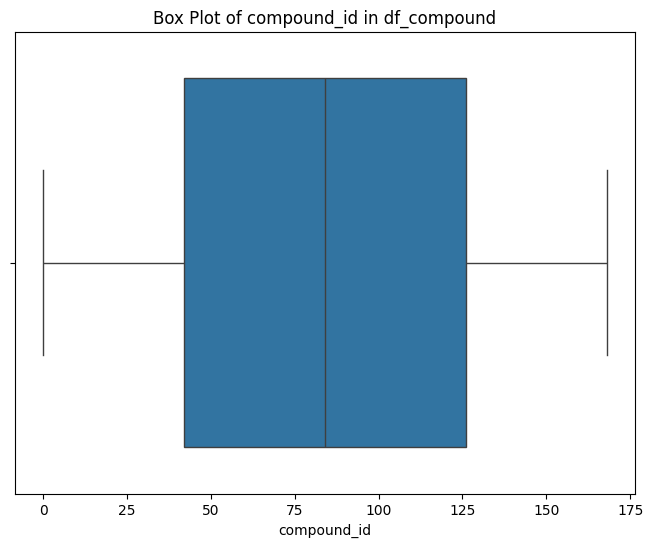

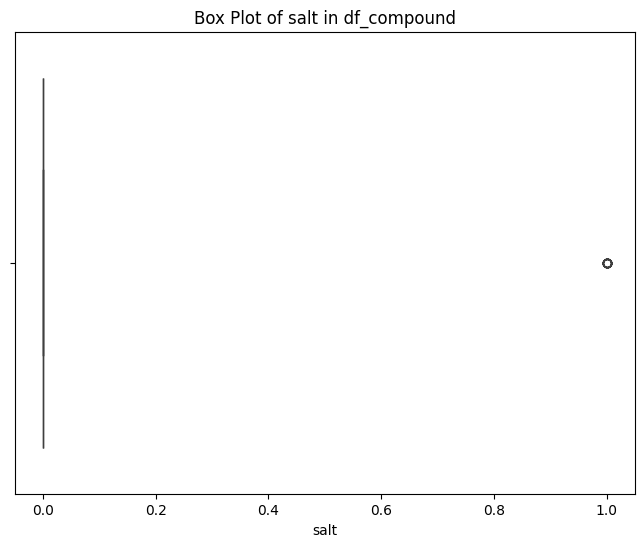

In [ ]:
# Check for outliers in df_compound (numerical columns)
numerical_cols_compound = df_compound.select_dtypes(include=np.number).columns

for col in numerical_cols_compound:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df_compound[col])
    plt.title(f'Box Plot of {col} in df_compound')
    plt.xlabel(col)
    plt.show()

## 1.1 Feature Engineering - Break the cmp_ids_solvent and cmp_mole_fractions_solvent into separate columns

In [ ]:
# Convert string columns into list columns
import ast  # safely evaluate strings as Python literals

# Convert the column to string before applying ast.literal_eval
df['cmp_ids_solvent'] = df['cmp_ids_solvent'].astype(str).apply(ast.literal_eval)
df['cmp_mole_fractions_solvent'] = df['cmp_mole_fractions_solvent'].astype(str).apply(ast.literal_eval)

# Split into separate columns while keeping correlation
# Define data extraction function
def extract_solvent_info(row, index):
    try:
        return row['cmp_ids_solvent'][index], row['cmp_mole_fractions_solvent'][index]
    except IndexError:
        return None, None  # For mixtures that have fewer solvents

# Apply to create new columns
df[['Solvent1_id', 'Solvent1_frac']] = df.apply(lambda row: pd.Series(extract_solvent_info(row, 0)), axis=1)
df[['Solvent2_id', 'Solvent2_frac']] = df.apply(lambda row: pd.Series(extract_solvent_info(row, 1)), axis=1)

# Map solvent IDs to names
id_to_name = dict(zip(df_compound['compound_id'], df_compound['name']))

df['Solvent1_name'] = df['Solvent1_id'].map(id_to_name)
df['Solvent2_name'] = df['Solvent2_id'].map(id_to_name)

## 1.2 SMILES and RDKit Mol Objects for Flutamide and Solvents

In [ ]:
df_49 = df[df['cmp_ids_drug'].astype(str).str.strip() == '[49]'].copy()

# Get the SMILES for the drug (Flutamide, cmp_id=49)
drug_smiles_49 = df_compound[df_compound['compound_id'] == 49]['smiles'].iloc[0]
df_49['drug_mol'] = df_49['cmp_ids_drug'].apply(lambda x: Chem.MolFromSmiles(drug_smiles_49))

# Map solvent IDs to SMILES
id_to_smiles = dict(zip(df_compound['compound_id'], df_compound['smiles']))

df_49['Solvent1_smiles'] = df_49['Solvent1_id'].map(id_to_smiles)
df_49['Solvent2_smiles'] = df_49['Solvent2_id'].map(id_to_smiles)

# Create Mol objects for solvents, handling NaN for single solvent systems
df_49['Solvent1_mol'] = df_49['Solvent1_smiles'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notna(x) else None)
df_49['Solvent2_mol'] = df_49['Solvent2_smiles'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notna(x) else None)

## 1.3 Hydrogen Bonding (HBA & HBD), Polarity (logP & TPSA) Features for Solute and Solvent

In [ ]:
def get_molecular_properties(df):
  # Helper function to ensure descriptor columns exist for a given prefix
  def _check_descriptor_columns(df_target, prefix):
    descriptors = ['HBA', 'HBD', 'logP', 'TPSA']
    for desc in descriptors:
      col_name = f'{prefix}_{desc}'
      if col_name not in df_target.columns:
        df_target[col_name] = None

  # Ensure descriptor columns exist for drug, Solvent1, and Solvent2
  _check_descriptor_columns(df, 'drug')
  _check_descriptor_columns(df, 'Solvent1')
  _check_descriptor_columns(df, 'Solvent2')

  for index, row in df.iterrows():
    drug_mol = row['drug_mol']
    Solvent1_mol = row['Solvent1_mol']
    Solvent2_mol = row['Solvent2_mol']

    if drug_mol is not None:
      df.at[index, 'drug_HBA'] = Descriptors.NumHAcceptors(drug_mol)
      df.at[index, 'drug_HBD'] = Descriptors.NumHDonors(drug_mol)
      df.at[index, 'drug_logP'] = Descriptors.MolLogP(drug_mol)
      df.at[index, 'drug_TPSA'] = rdMolDescriptors.CalcTPSA(drug_mol)


    if Solvent1_mol is not None:
      df.at[index, 'Solvent1_HBA'] = Descriptors.NumHAcceptors(Solvent1_mol)
      df.at[index, 'Solvent1_HBD'] = Descriptors.NumHDonors(Solvent1_mol)
      df.at[index, 'Solvent1_logP'] = Descriptors.MolLogP(Solvent1_mol)
      df.at[index, 'Solvent1_TPSA'] = rdMolDescriptors.CalcTPSA(Solvent1_mol)

    if Solvent2_mol is not None:
      df.at[index, 'Solvent2_HBA'] = Descriptors.NumHAcceptors(Solvent2_mol)
      df.at[index, 'Solvent2_HBD'] = Descriptors.NumHDonors(Solvent2_mol)
      df.at[index, 'Solvent2_logP'] = Descriptors.MolLogP(Solvent2_mol)
      df.at[index, 'Solvent2_TPSA'] = rdMolDescriptors.CalcTPSA(Solvent2_mol)

  return df
df_49 = get_molecular_properties(df_49)

## 1.4 Dielectric Constant and Hansen Parametes for Solvents

In [ ]:
# -------------------------------------------------
# 1. Reference / experimental data
# -------------------------------------------------
water_coeffs = {"A": 87.740, "B": -0.400081, "C": 9.398e-4, "D": -1.410e-6}

# Updated solvent names and standardized 'THF' to 'Tetrahydrofuran'
eps_ref = {
    "Ethanol": 24.5,
    "2-Propanol": 19.92,
    "1,4-Dioxane": 2.25,
    "Acetonitrile": 37.5,
    "Acetone": 20.7,
    "Ethyl Acetate": 6.02,
    "Tetrahydrofuran": 7.58, # Changed from "THF"
    "Water": None  # handled separately
}

alphas = {
    "Ethanol": 0.018,
    "2-Propanol": 0.018,
    "1,4-Dioxane": 0.012,
    "Acetonitrile": 0.017,
    "Acetone": 0.020,
    "Ethyl Acetate": 0.015,
    "Tetrahydrofuran": 0.014 # Changed from "THF"
}

hansen_298 = {
    "Water": {"dD":15.5, "dP":16.0, "dH":42.3},
    "Ethanol": {"dD":15.8, "dP":8.8, "dH":19.4},
    "2-Propanol": {"dD":16.0, "dP":6.1, "dH":16.4},
    "1,4-Dioxane": {"dD":19.0, "dP":1.8, "dH":7.4},
    "Acetonitrile": {"dD":15.3, "dP":18.0, "dH":6.1},
    "Acetone": {"dD":15.5, "dP":10.4, "dH":7.0},
    "Ethyl Acetate": {"dD":15.8, "dP":5.3, "dH":7.2},
    "Tetrahydrofuran": {"dD":16.8, "dP":5.7, "dH":8.0} # Changed from "THF"
}

# -------------------------------------------------
# 2. Dielectric functions
# -------------------------------------------------
def epsilon_water(T_kelvin):
    T_C = T_kelvin - 273.15
    A, B, C, D = water_coeffs["A"], water_coeffs["B"], water_coeffs["C"], water_coeffs["D"]
    return A + B*T_C + C*T_C**2 + D*T_C**3

def epsilon_solvent(solvent, T_kelvin):
    # Ensure proper capitalization and handle potential NaN from solvent.title() for non-string types
    if pd.isna(solvent):
        return np.nan
    solvent_cap = solvent.title().replace("Tetrahydrofuran", "Tetrahydrofuran") # already standardized above
    if solvent_cap == "Water":
        return epsilon_water(T_kelvin)
    if solvent_cap not in eps_ref:
        # If a solvent name is not found, return NaN for its dielectric constant
        return np.nan
    eps0 = eps_ref[solvent_cap]
    alpha = alphas[solvent_cap]
    T_C = T_kelvin - 273.15
    return eps0 * np.exp(-alpha * (T_C - 25))

# -------------------------------------------------
# 3. Hansen parameters
# -------------------------------------------------
def hansen_T(solvent, T_kelvin, beta=0.008, gamma=8e-4):
    if pd.isna(solvent):
        return np.nan, np.nan, np.nan
    solvent_cap = solvent.title().replace("Tetrahydrofuran", "Tetrahydrofuran") # already standardized above
    if solvent_cap not in hansen_298:
        # If a solvent name is not found, return NaN for its Hansen parameters
        return np.nan, np.nan, np.nan
    h298 = hansen_298[solvent_cap]
    T0 = 298.15
    scale = 1 / (1 + gamma*(T_kelvin - T0))
    dD_T = h298["dD"] * scale
    dP_T = h298["dP"] * scale
    dH_T = h298["dH"] * np.exp(-beta*(T_kelvin - T0))
    return dD_T, dP_T, dH_T

# -------------------------------------------------
# 4. Apply to DataFrame (modified to accept a prefix for new columns)
# -------------------------------------------------
def add_solvent_properties(df, temp_col='Temperature, K', solvent_col='Solvent', prefix=''):
    dielectrics = []
    dD_list, dP_list, dH_list = [], [], []

    # Capitalize solvent names consistently, handling NaN values
    df[solvent_col] = df[solvent_col].apply(
        lambda x: "Tetrahydrofuran" if pd.notna(x) and str(x).lower() == "tetrahydrofuran" else (str(x).title() if pd.notna(x) else np.nan)
    )

    for _, row in df.iterrows():
        T = row[temp_col]
        solvent = row[solvent_col]

        # Only calculate if solvent is not NaN
        if pd.notna(solvent):
            dielectrics.append(epsilon_solvent(solvent, T))
            dD, dP, dH = hansen_T(solvent, T)
            dD_list.append(dD)
            dP_list.append(dP)
            dH_list.append(dH)
        else:
            dielectrics.append(np.nan)
            dD_list.append(np.nan)
            dP_list.append(np.nan)
            dH_list.append(np.nan)

    df[f'{prefix}Dielectric'] = dielectrics
    df[f'{prefix}δD'] = dD_list
    df[f'{prefix}δP'] = dP_list
    df[f'{prefix}δH'] = dH_list
    return df

# Include solvent 1 and solvent 2 dielectric constant and Hansen parameters
df_49 = add_solvent_properties(df_49, temp_col='Temperature, K', solvent_col='Solvent1_name', prefix='Solvent1_')
df_49 = add_solvent_properties(df_49, temp_col='Temperature, K', solvent_col='Solvent2_name', prefix='Solvent2_')

#df_49.columns

## 1.5 Hansen Parameter for Solute - Flutamide

In [ ]:
# Flutamide estimated Hansen parameters (room temp, 298 K)
flutamide_hansen = {"dD": 17.0, "dP": 8.0, "dH": 7.0}  # approximate sum of contributions

def hansen_solute_T(solute_name, T_kelvin, beta=0.008, gamma=8e-4):
    """
    Returns Hansen parameters for the solute.
    Currently only handles flutamide; extendable to other solutes.
    """
    if solute_name.lower() != "flutamide":
        raise ValueError("Solute not supported. Only 'flutamide' is implemented.")

    T0 = 298.15
    scale = 1 / (1 + gamma*(T_kelvin - T0))
    h298 = flutamide_hansen # Since it's hardcoded for flutamide
    dD_T = h298["dD"] * scale
    dP_T = h298["dP"] * scale
    dH_T = h298["dH"] * np.exp(-beta*(T_kelvin - T0))
    return dD_T, dP_T, dH_T

# Apply the function row-wise, passing the string 'flutamide' as the solute_name and expanding the returned tuple into new columns
df_49[['drug_δD', 'drug_δP', 'drug_δH']] = df_49.apply(
    lambda row: hansen_solute_T("flutamide", row['Temperature, K']),
    axis=1,
    result_type='expand'
)

## 1.6 Hansen Distance (Ra) for Solvent1 and Solvent2

In [ ]:
# Function to calculate Hansen Distance (Ra)
def hansen_distance_Ra(dD1, dP1, dH1, dD2, dP2, dH2):
    if any(pd.isna(x) for x in [dD1, dP1, dH1, dD2, dP2, dH2]):
        return np.nan
    return np.sqrt(4 * (dD2 - dD1)**2 + (dP2 - dP1)**2 + (dH2 - dH1)**2)

# Calculate Ra for Solvent1 against Solvent2
df_49['Solvent1_Solvent2_Ra'] = df_49.apply(
    lambda row: hansen_distance_Ra(
        row['Solvent1_δD'], row['Solvent1_δP'], row['Solvent1_δH'],
        row['Solvent2_δD'], row['Solvent2_δP'], row['Solvent2_δH']
    ) if pd.notna(row['Solvent1_name']) else np.nan,
    axis=1
)

#df_49.head()

## 1.7 Dielectric Constant for Flutamide

In [ ]:
# Flutamide estimated dielectric constant (approximate)
def dielectric_solute(solute, T_kelvin):
    """
    Returns an estimated dielectric constant for small molecule solutes.
    Currently only handles flutamide.
    """
    if solute.lower() != "flutamide":
        raise ValueError("Solute not supported. Only 'flutamide' is implemented.")
    # Room temperature reference
    eps0 = 8.0  # approximate
    # optional temperature decay (small)
    alpha = 0.002  # small negative temperature dependence
    T0 = 298.15
    return eps0 * np.exp(-alpha * (T_kelvin - T0))

# Add estimated flutamide dielectric
df_49['drug_Dielectric'] = dielectric_solute('Flutamide', df_49['Temperature, K'])

#df_49.head()

## 1.8 Morgan Fingerprint for Solute and Solvents

In [ ]:
# Create Morgan fingerprint generator
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)

# Generate Morgan fingerprints for solute and solvents
df_49['drug_fp'] = df_49['drug_mol'].apply(lambda x: morgan_gen.GetFingerprint(x) if x is not None else None)
df_49['Solvent1_fp'] = df_49['Solvent1_mol'].apply(lambda x: morgan_gen.GetFingerprint(x) if x is not None else None)
df_49['Solvent2_fp'] = df_49['Solvent2_mol'].apply(lambda x: morgan_gen.GetFingerprint(x) if x is not None else None)

## 1.9 Isometric Log-Ratio (ILR) Coordinate for Solvent Compositions

In [ ]:
# Function for calculating ILR coordinate for solvents
def ilr_binary(solvent1, solvent2, eps=1e-12):
    x1 = np.maximum(solvent1, eps)
    x2 = np.maximum(solvent2, eps)
    return np.sqrt(1/2) * np.log(x1 / x2)

df_49['ILR_coordinate'] = ilr_binary(df_49['Solvent1_frac'], df_49['Solvent2_frac'])

## 1.10 Develop Mole Fraction Weighted Solvent Features - HBA, HBD, logP, TPSA, Dielectric Constant, and Morgan Fingerprints

In [ ]:
from rdkit import DataStructs # Required for handling fingerprints

# Assuming morgan_gen is available from a previous cell
# If not, it needs to be created or passed as an argument.
# For example: morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)
fp_size = 2048 # Explicitly set fingerprint size to the value used during generation

# List of numerical molecular features to be weighted
molecular_features = ['HBA', 'HBD', 'logP', 'TPSA', 'Dielectric']

# Apply weighting for numerical features
for feature in molecular_features:
    col_s1 = f'Solvent1_{feature}'
    col_s2 = f'Solvent2_{feature}'
    # Perform weighted average, handling potential NaN values if a solvent is missing
    # fillna(0) for fractions ensures that if Solvent1_frac is NaN, its contribution is zero.
    # fillna(0) for feature values ensures that if Solvent1_HBA is NaN, it's treated as 0 for calculation.
    df_49[f'weighted_{feature}'] = (df_49[col_s1].fillna(0) * df_49['Solvent1_frac'].fillna(0) +
                                   df_49[col_s2].fillna(0) * df_49['Solvent2_frac'].fillna(0))

# Handle Morgan fingerprints separately

def weighted_fingerprint_array(row):
    s1_fp = row['Solvent1_fp']
    s2_fp = row['Solvent2_fp']
    s1_frac = row['Solvent1_frac']
    s2_frac = row['Solvent2_frac']

    s1_arr = np.zeros(fp_size, dtype=float)
    if s1_fp is not None:
        DataStructs.ConvertToNumpyArray(s1_fp, s1_arr)

    s2_arr = np.zeros(fp_size, dtype=float)
    if s2_fp is not None:
        DataStructs.ConvertToNumpyArray(s2_fp, s2_arr)

    # If a fraction is NaN, treat its contribution as 0
    weighted_s1 = s1_arr * (s1_frac if pd.notna(s1_frac) else 0)
    weighted_s2 = s2_arr * (s2_frac if pd.notna(s2_frac) else 0)

    return weighted_s1 + weighted_s2

df_49['weighted_fp'] = df_49.apply(weighted_fingerprint_array, axis=1)

# Display the dataframe with new weighted columns (optional, for verification)
#display(df_49)

/tmp/ipython-input-1943542783.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_49[f'weighted_{feature}'] = (df_49[col_s1].fillna(0) * df_49['Solvent1_frac'].fillna(0) +
/tmp/ipython-input-1943542783.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_49[col_s2].fillna(0) * df_49['Solvent2_frac'].fillna(0))
/tmp/ipython-input-1943542783.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior

## 2.1 Check Feature Variances / Missing Data / Duplicates

In [ ]:
#df_49.info()
#df_49.describe()

In [ ]:
import numpy as np # Import numpy if not already imported in this scope

# Check the variances of each feature
# Exclude fingerprint columns as they are not numerical and cannot have variance calculated directly
features_to_check = [ 'drug_HBA', 'drug_HBD', 'drug_logP', 'drug_TPSA', 'drug_Dielectric', 'drug_δD', 'drug_δP', 'drug_δH',
                     'Solvent1_HBA', 'Solvent1_HBD', 'Solvent1_frac','Solvent1_logP', 'Solvent1_TPSA',
                      'Solvent1_Dielectric', 'Solvent1_δD','Solvent1_δP', 'Solvent1_δH',
                      'Solvent2_frac','Solvent2_HBA', 'Solvent2_HBD','Solvent2_logP', 'Solvent2_TPSA',
                      'Solvent2_Dielectric', 'Solvent2_δD', 'Solvent2_δP', 'Solvent2_δH',
                      'Solvent1_Solvent2_Ra', 'ILR_coordinate', 'weighted_HBA', 'weighted_HBD',
                      'weighted_logP', 'weighted_TPSA', 'weighted_Dielectric']
feature_variances = []
feature_small_variances = []

feature_variance_threshold = 1e-5
for feature in features_to_check:
    if np.issubdtype(df_49[feature].dtype, np.number):
        variance = df_49[feature].var()
        feature_variances.append((feature, variance))
        if variance < feature_variance_threshold:
          feature_small_variances.append((feature,variance))

    else:
        feature_variances.append((feature, 'Not Applicable (Non-numeric)'))

display(feature_variances)
print(f'\n features with small variances ({feature_variance_threshold}):')
display(feature_small_variances)

# The variances of numerical features aren't small enough, so it's decided that no feature is dropped.

[('drug_HBA', 'Not Applicable (Non-numeric)'),
 ('drug_HBD', 'Not Applicable (Non-numeric)'),
 ('drug_logP', 'Not Applicable (Non-numeric)'),
 ('drug_TPSA', 'Not Applicable (Non-numeric)'),
 ('drug_Dielectric', 0.05116844473282817),
 ('drug_δD', 0.037048165722233205),
 ('drug_δP', 0.008204438083816323),
 ('drug_δH', 0.6122883110168309),
 ('Solvent1_HBA', 'Not Applicable (Non-numeric)'),
 ('Solvent1_HBD', 'Not Applicable (Non-numeric)'),
 ('Solvent1_frac', 0.08845099271205835),
 ('Solvent1_logP', 'Not Applicable (Non-numeric)'),
 ('Solvent1_TPSA', 'Not Applicable (Non-numeric)'),
 ('Solvent1_Dielectric', 209.67126964213907),
 ('Solvent1_δD', 1.344129503269101),
 ('Solvent1_δP', 24.036071999535622),
 ('Solvent1_δH', 41.25729256241237),
 ('Solvent2_frac', 0.06811262949037754),
 ('Solvent2_HBA', 'Not Applicable (Non-numeric)'),
 ('Solvent2_HBD', 'Not Applicable (Non-numeric)'),
 ('Solvent2_logP', 'Not Applicable (Non-numeric)'),
 ('Solvent2_TPSA', 'Not Applicable (Non-numeric)'),
 ('Solven


 features with small variances (1e-05):


[]

In [ ]:
# Check missing data in df and df_compound
print(f'Missing Data in df_49: \n{df_49.isnull().sum()}\n')

# Convert list columns to tuples to make them hashable for duplicated()
# Apply this transformation on a copy to avoid SettingWithCopyWarning if df_49 is a slice
df_49_copy = df_49.copy()
df_49_copy['cmp_ids_solvent'] = df_49_copy['cmp_ids_solvent'].apply(tuple)
df_49_copy['cmp_mole_fractions_solvent'] = df_49_copy['cmp_mole_fractions_solvent'].apply(tuple)
df_49_copy['cmp_ids_drug'] = df_49_copy['cmp_ids_drug'].apply(tuple)
df_49_copy['cmp_mole_fractions_drug'] = df_49_copy['cmp_mole_fractions_drug'].apply(tuple)

# Identify columns that contain unhashable types like RDKit Mol objects or numpy arrays
unhashable_cols = []
for col in df_49_copy.columns:
    # Check if any element in the column is an RDKit Mol object or a numpy array
    # Use .any() to efficiently check if at least one such element exists
    if df_49_copy[col].apply(lambda x: isinstance(x, (Chem.Mol, np.ndarray))).any():
        unhashable_cols.append(col)

# Define a subset of columns for checking duplicates, excluding unhashable columns
subset_cols_for_duplicates = [col for col in df_49_copy.columns if col not in unhashable_cols]

# Check duplicates in df_49
duplicates = df_49_copy[df_49_copy.duplicated(subset=subset_cols_for_duplicates)]
print(f'\nDuplicates in df_49:\n{duplicates}')

Missing Data in df_49: 
value                          0
Temperature, K                 0
property                       0
unit                           0
cmp_ids_solvent                0
cmp_mole_fractions_solvent     0
cmp_ids_drug                   0
cmp_mole_fractions_drug        0
Solvent1_id                    0
Solvent1_frac                  0
Solvent2_id                   49
Solvent2_frac                 49
Solvent1_name                  0
Solvent2_name                 49
drug_mol                       0
Solvent1_smiles                0
Solvent2_smiles               49
Solvent1_mol                   0
Solvent2_mol                  49
drug_HBA                       0
drug_HBD                       0
drug_logP                      0
drug_TPSA                      0
Solvent1_HBA                   0
Solvent1_HBD                   0
Solvent1_logP                  0
Solvent1_TPSA                  0
Solvent2_HBA                  49
Solvent2_HBD                  49
Solvent2_logP      

## 2.2 Correlation Analysis Between Features and Target

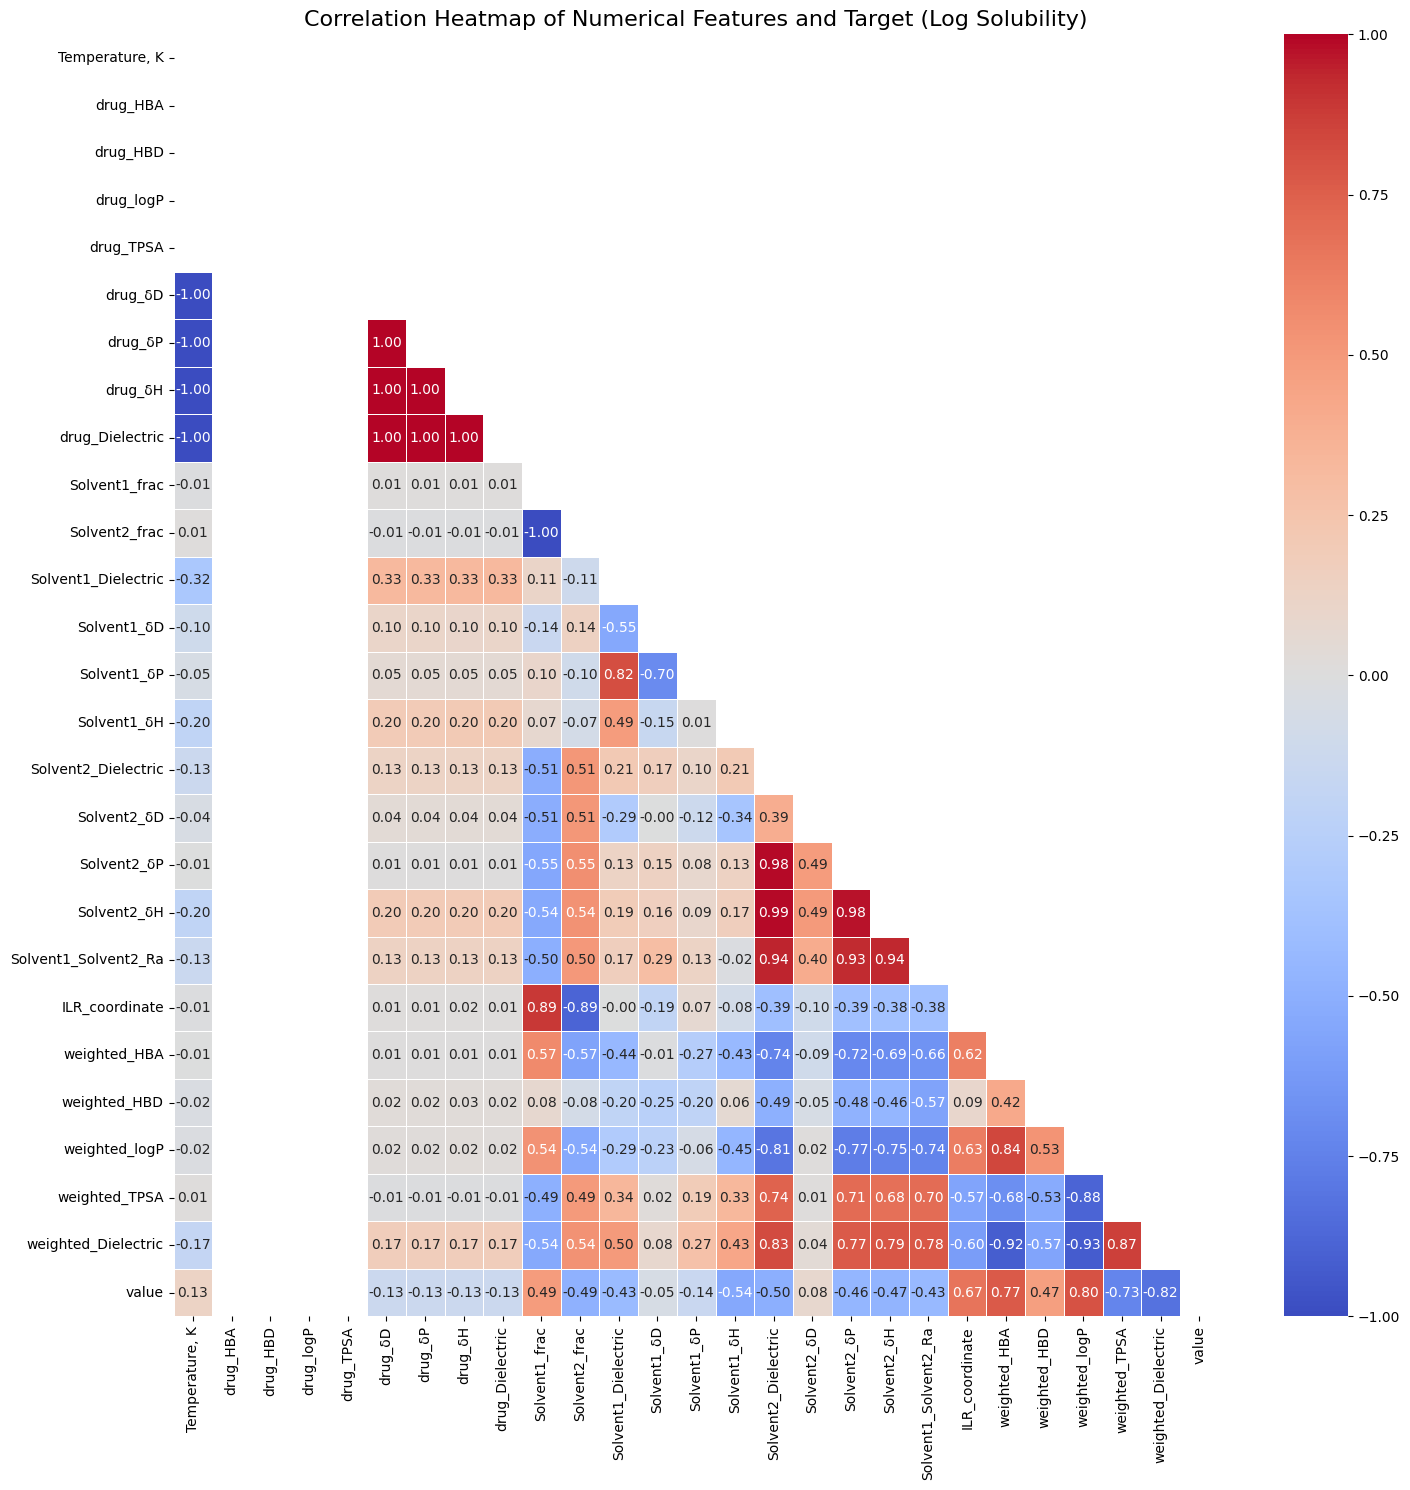


Correlation with Target Variable ('value'):
value                   1.000000
weighted_logP           0.800675
weighted_HBA            0.767912
ILR_coordinate          0.669573
Solvent1_frac           0.488742
weighted_HBD            0.469875
Temperature, K          0.126170
Solvent2_δD             0.081065
Solvent1_δD            -0.047065
drug_δH                -0.125937
drug_Dielectric        -0.126144
drug_δD                -0.126151
drug_δP                -0.126151
Solvent1_δP            -0.141411
Solvent1_Dielectric    -0.425882
Solvent1_Solvent2_Ra   -0.433548
Solvent2_δP            -0.455894
Solvent2_δH            -0.470666
Solvent2_frac          -0.488742
Solvent2_Dielectric    -0.504084
Solvent1_δH            -0.543192
weighted_TPSA          -0.730849
weighted_Dielectric    -0.822935
drug_HBA                     NaN
drug_HBD                     NaN
drug_logP                    NaN
drug_TPSA                    NaN
Name: value, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define the target variable
TARGET = 'value'

# Define numerical and molecular features (excluding fingerprints for heatmap readability)
# These are the same as used previously, without the fingerprint expansion
FEATURES_NO_FP = [
    'Temperature, K',
    'drug_HBA', 'drug_HBD', 'drug_logP', 'drug_TPSA',
    'drug_δD', 'drug_δP', 'drug_δH', 'drug_Dielectric',
    'Solvent1_frac', 'Solvent2_frac',
    'Solvent1_Dielectric', 'Solvent1_δD', 'Solvent1_δP', 'Solvent1_δH',
    'Solvent2_Dielectric', 'Solvent2_δD', 'Solvent2_δP', 'Solvent2_δH',
    'Solvent1_Solvent2_Ra',
    'ILR_coordinate',
    'weighted_HBA', 'weighted_HBD', 'weighted_logP', 'weighted_TPSA', 'weighted_Dielectric'
]

# Create a DataFrame with only the selected features and the target variable
df_selected_features = df_49[FEATURES_NO_FP + [TARGET]].copy() # Ensure df_49 is defined by running previous cells

# Impute missing values with 0 for correlation calculation (as done in models)
# This is important to ensure all values are numeric for correlation matrix
for col in df_selected_features.columns:
    if df_selected_features[col].dtype == 'object':
        # Attempt to convert to numeric, coercing errors to NaN
        df_selected_features[col] = pd.to_numeric(df_selected_features[col], errors='coerce')
    # Fill remaining NaNs (from original data or coercing) with 0
    df_selected_features[col] = df_selected_features[col].fillna(0)

# Calculate the correlation matrix
correlation_matrix = df_selected_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)
plt.title('Correlation Heatmap of Numerical Features and Target (Log Solubility)', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Display correlations with the target variable ('value')
print("\nCorrelation with Target Variable ('value'):")
print(correlation_matrix[TARGET].sort_values(ascending=False))


Features dropped:
1. Solvent 1 and 2 mole fraction
They won't be used in the following machine learning process since the ILR_coordinate encapsulates the ratio of these fractions.

2. drug_HBA, drug_HBD, drug_logP, drug_TPSA
Since there is only one solute studied in this project, these features are always constant, and a machine learning model cannot learn any relationship between a constant feature and the target variable.

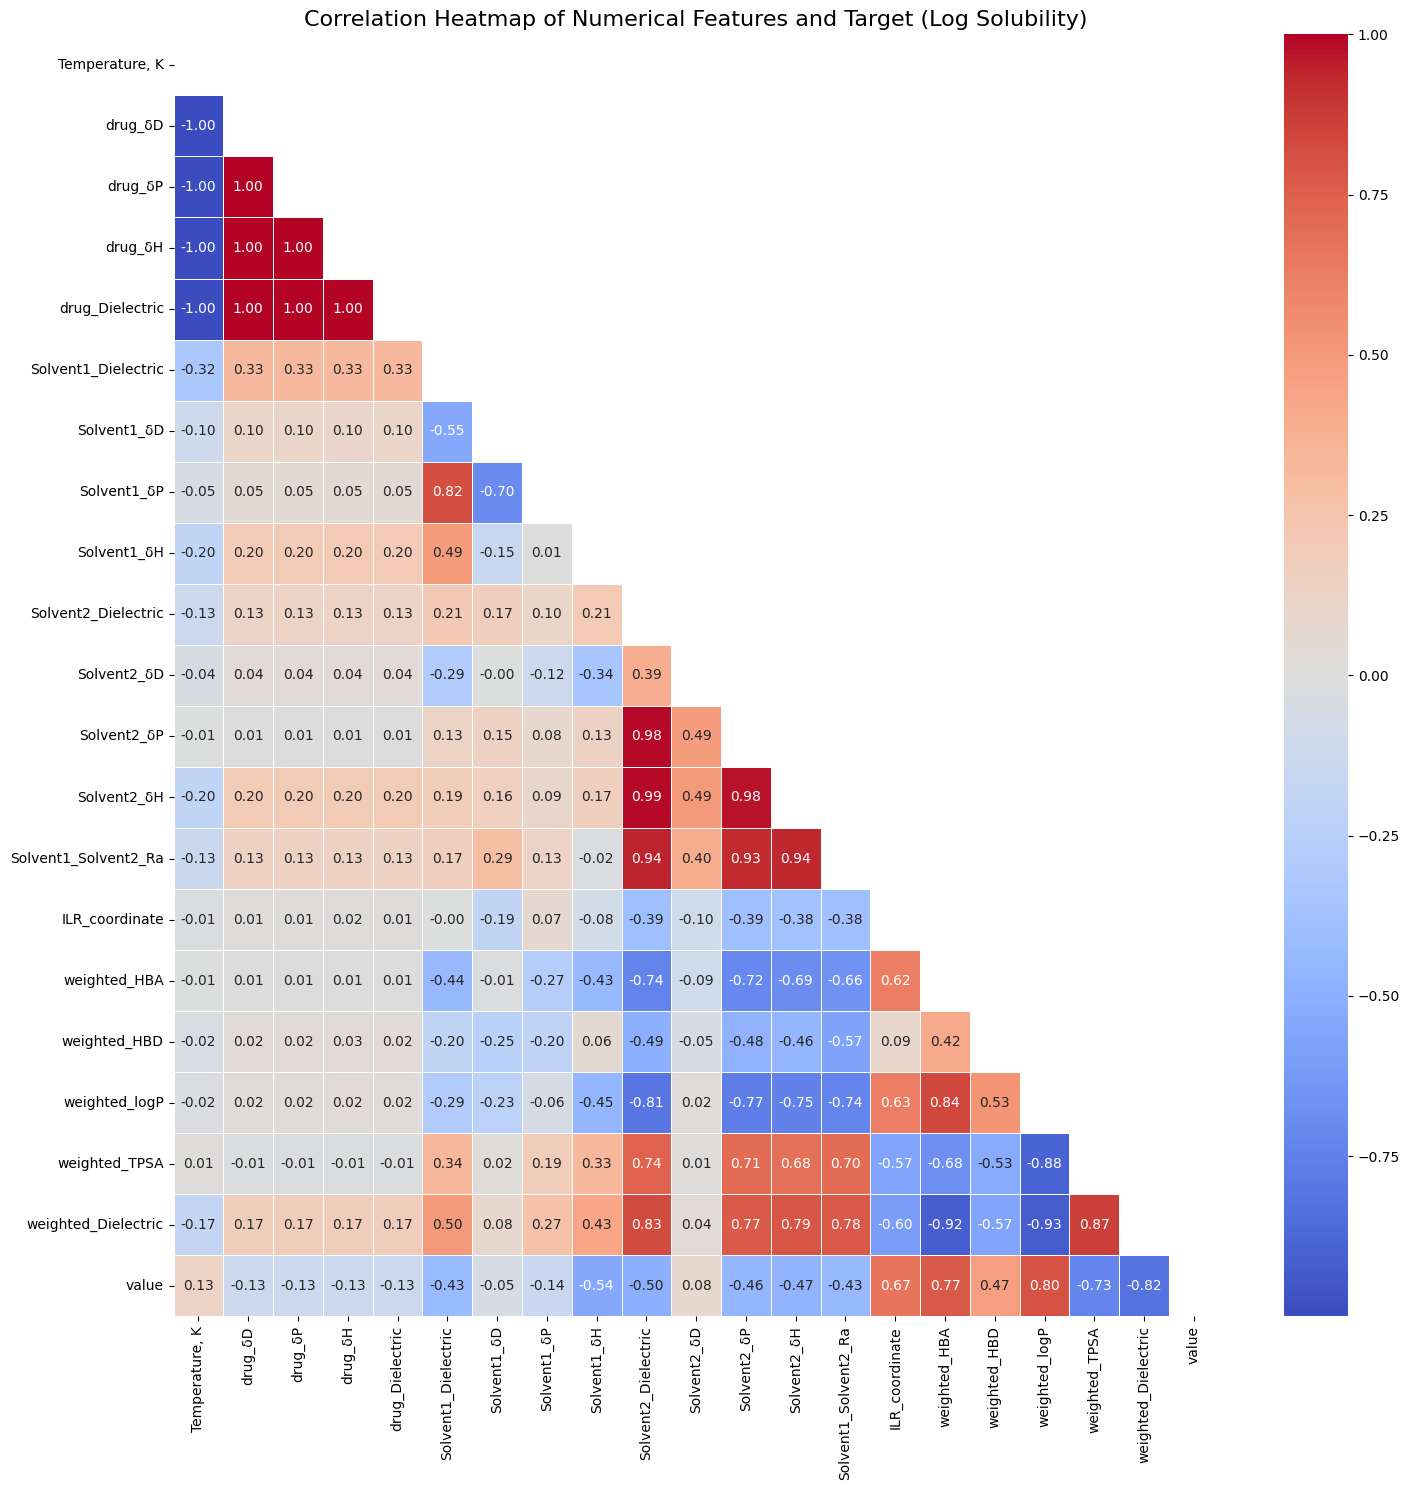


Correlation with Target Variable ('value'):
value                   1.000000
weighted_logP           0.800675
weighted_HBA            0.767912
ILR_coordinate          0.669573
weighted_HBD            0.469875
Temperature, K          0.126170
Solvent2_δD             0.081065
Solvent1_δD            -0.047065
drug_δH                -0.125937
drug_Dielectric        -0.126144
drug_δD                -0.126151
drug_δP                -0.126151
Solvent1_δP            -0.141411
Solvent1_Dielectric    -0.425882
Solvent1_Solvent2_Ra   -0.433548
Solvent2_δP            -0.455894
Solvent2_δH            -0.470666
Solvent2_Dielectric    -0.504084
Solvent1_δH            -0.543192
weighted_TPSA          -0.730849
weighted_Dielectric    -0.822935
Name: value, dtype: float64


In [ ]:
# Define the target variable
TARGET = 'value'

# These are the same as used previously, without the fingerprint expansion
FEATURES_NO_FP = [
    'Temperature, K',
    'drug_δD', 'drug_δP', 'drug_δH', 'drug_Dielectric',
    'Solvent1_Dielectric', 'Solvent1_δD', 'Solvent1_δP', 'Solvent1_δH',
    'Solvent2_Dielectric', 'Solvent2_δD', 'Solvent2_δP', 'Solvent2_δH',
    'Solvent1_Solvent2_Ra', 'ILR_coordinate',
    'weighted_HBA', 'weighted_HBD', 'weighted_logP', 'weighted_TPSA', 'weighted_Dielectric'
]

# Create a DataFrame with only the selected features and the target variable
df_selected_features = df_49[FEATURES_NO_FP + [TARGET]].copy() # Ensure df_49 is defined by running previous cells

# Impute missing values with 0 for correlation calculation (as done in models)
# This is important to ensure all values are numeric for correlation matrix
for col in df_selected_features.columns:
    if df_selected_features[col].dtype == 'object':
        # Attempt to convert to numeric, coercing errors to NaN
        df_selected_features[col] = pd.to_numeric(df_selected_features[col], errors='coerce')
    # Fill remaining NaNs (from original data or coercing) with 0
    df_selected_features[col] = df_selected_features[col].fillna(0)

# Calculate the correlation matrix
correlation_matrix = df_selected_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)
plt.title('Correlation Heatmap of Numerical Features and Target (Log Solubility)', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Display correlations with the target variable ('value')
print("\nCorrelation with Target Variable ('value'):")
print(correlation_matrix[TARGET].sort_values(ascending=False))

## 2.3 Univariate Analysis - Flutamide Log Solubility and Temperature Distribution

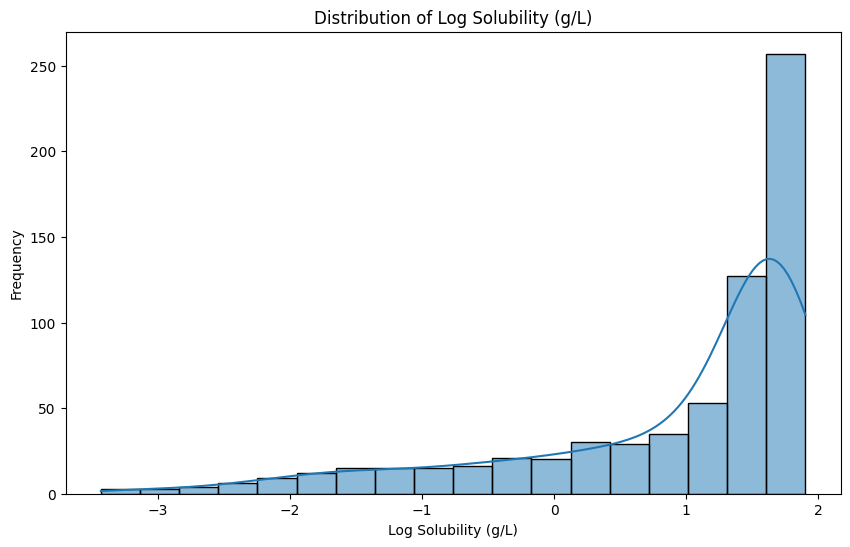

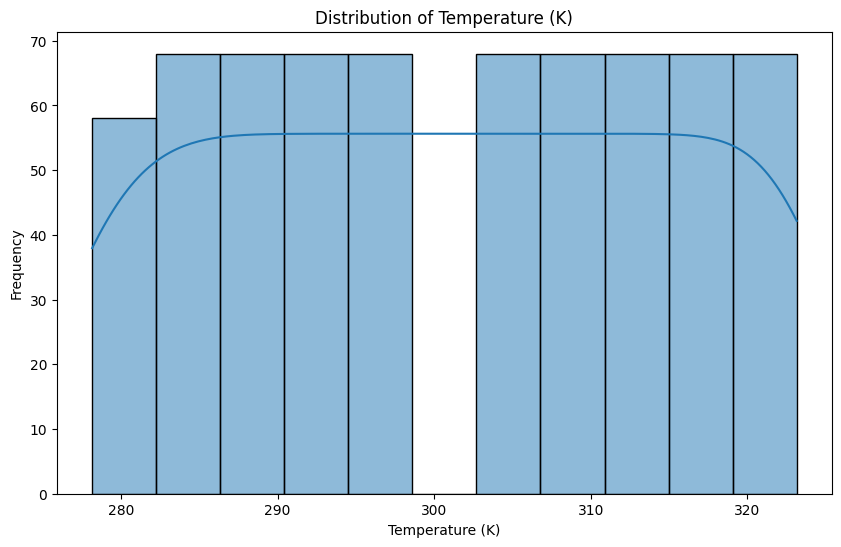

In [ ]:
# Filter the data for drug with cmp_ids_drug as "[49]"
df_49 = df[df['cmp_ids_drug'].astype(str).str.strip() == '[49]'].copy()

# Create a histogram and density plot for 'value' (Log Solubility)
plt.figure(figsize=(10, 6))
sns.histplot(data=df_49, x='value', kde=True)
plt.title('Distribution of Log Solubility (g/L)')
plt.xlabel('Log Solubility (g/L)')
plt.ylabel('Frequency')
plt.show()
print('\n')

# Create a histogram and density plot for 'Temperature, K'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_49, x='Temperature, K', kde=True)
plt.title('Distribution of Temperature (K)')
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.show()

Number of Solubility Data Points Per Solvent Combination

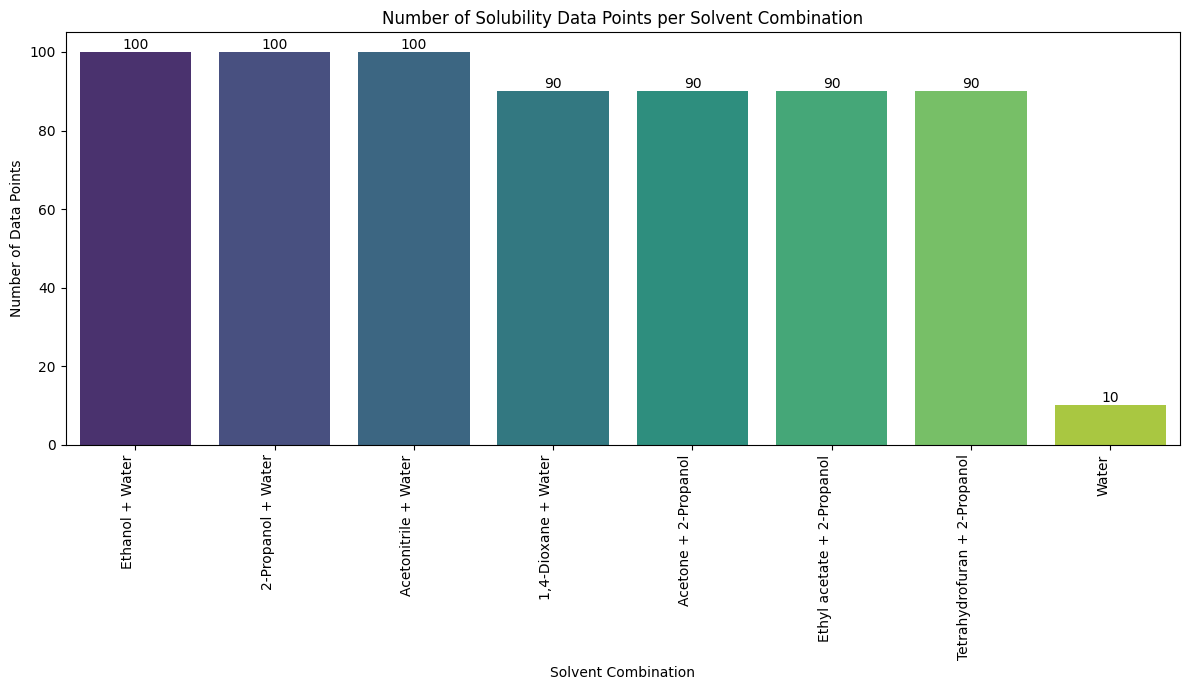

In [ ]:
# Re-define extract_solvent_info function to ensure it's available
def extract_solvent_info(row, index):
    try:
        return row['cmp_ids_solvent'][index], row['cmp_mole_fractions_solvent'][index]
    except IndexError:
        return None, None

# Extract Solvent1 and Solvent2 information (ids and fractions)
# Check if columns already exist to avoid re-creating them unnecessarily if the cell was rerun partly
if 'Solvent1_id' not in df_49.columns:
    df_49[['Solvent1_id', 'Solvent1_frac']] = df_49.apply(lambda row: pd.Series(extract_solvent_info(row, 0)), axis=1)
if 'Solvent2_id' not in df_49.columns:
    df_49[['Solvent2_id', 'Solvent2_frac']] = df_49.apply(lambda row: pd.Series(extract_solvent_info(row, 1)), axis=1)

# Ensure id_to_name mapping is available
# Re-create if it's not in the global scope (e.g., if previous cells weren't run)
id_to_name = dict(zip(df_compound['compound_id'], df_compound['name']))

# Create a column for the base solvent combination names (without fractions) for grouping
df_49['solvent_combination_base_name'] = df_49['cmp_ids_solvent'].apply(lambda x: " + ".join([id_to_name.get(float(id), str(id)) for id in x]))

# Calculate the number of data points for each solvent combination
solvent_counts = df_49['solvent_combination_base_name'].value_counts()

# Create the bar graph
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=solvent_counts.index, y=solvent_counts.values, hue=solvent_counts.index, palette='viridis', legend=False)

# Add exact numbers on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.title('Number of Solubility Data Points per Solvent Combination')
plt.xlabel('Solvent Combination')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=90, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

## 2.4 Univariate Analysis - Distribution of Solvent 1 and 2 Mole Fractions

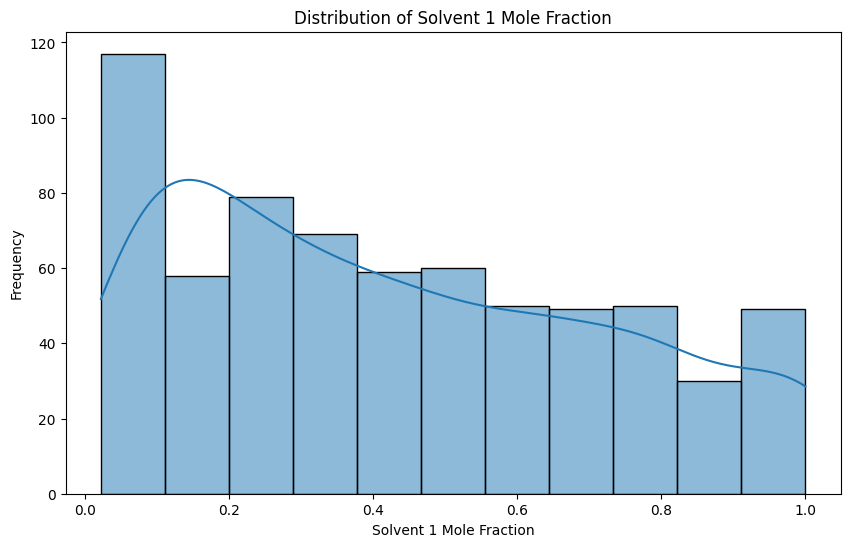

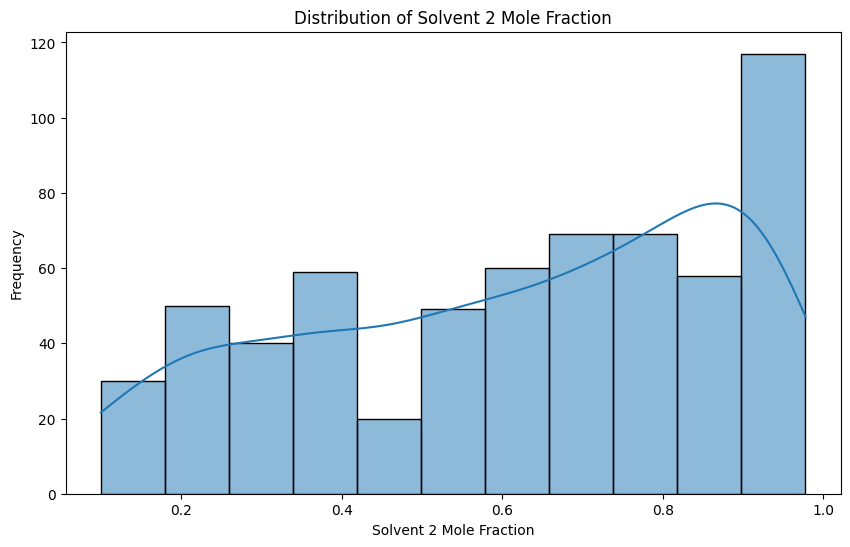

In [ ]:
# Create a histogram and density plot for 'Solvent1_frac'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_49, x='Solvent1_frac', kde=True)
plt.title('Distribution of Solvent 1 Mole Fraction')
plt.xlabel('Solvent 1 Mole Fraction')
plt.ylabel('Frequency')
plt.show()
print('\n')

# Create a histogram and density plot for 'Solvent2_frac'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_49, x='Solvent2_frac', kde=True)
plt.title('Distribution of Solvent 2 Mole Fraction')
plt.xlabel('Solvent 2 Mole Fraction')
plt.ylabel('Frequency')
plt.show()

## 2.5 Bivariate Analysis - Distribution of Flutamide Log Solubility by Temperature Range (Percentage) for Flutamide and Solvents

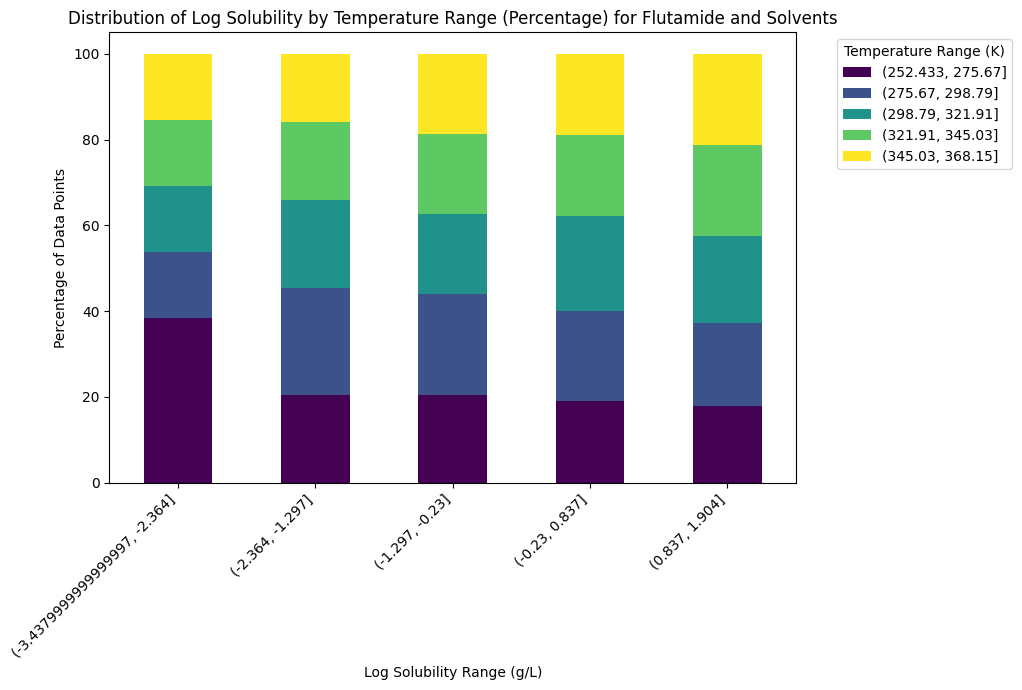

In [ ]:
# Create bins for temperature
num_bins_temp = 5  # Can adjust the number of bins as needed
df_49['Temperature_bin'] = pd.cut(df_49['Temperature, K'], bins=num_bins_temp, labels=False, include_lowest=True)

# Create bins for solubility
num_bins_solubility = 5 # Can adjust the number of bins as needed
df_49['Solubility_bin'] = pd.cut(df_49['value'], bins=num_bins_solubility, labels=False, include_lowest=True)

# Group by solubility bin and temperature bin and count the occurrences
grouped_data = df_49.groupby(['Solubility_bin', 'Temperature_bin']).size().unstack(fill_value=0)

# Normalize the data so each stack sums to 100%
percentage_data = grouped_data.apply(lambda x: x / x.sum(), axis=1) * 100

# Create a stacked bar chart using the percentage data
plt.figure(figsize=(12, 7))
ax = percentage_data.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca()) # Use a different colormap

# Set titles and labels
plt.title('Distribution of Log Solubility by Temperature Range (Percentage) for Flutamide and Solvents')
plt.xlabel('Log Solubility Range (g/L)')
plt.ylabel('Percentage of Data Points')

# Create custom legend labels based on temperature ranges
legend_labels = []
temp_bins = pd.cut(df['Temperature, K'], bins=num_bins_temp, include_lowest=True)
unique_temp_ranges = temp_bins.cat.categories
for i, temp_range in enumerate(unique_temp_ranges):
    legend_labels.append(f'{temp_range}')

plt.legend(title='Temperature Range (K)', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left') # Add a legend with custom labels

# Create custom x-axis labels based on solubility ranges
solubility_bins = pd.cut(df_49['value'], bins=num_bins_solubility, include_lowest=True)
unique_solubility_ranges = solubility_bins.cat.categories
x_labels = [f'{solubility_range}' for i, solubility_range in enumerate(unique_solubility_ranges)] # Removed 'Bin {i+1}: '
ax.set_xticklabels(x_labels)


# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right')

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for the legend
plt.show()

## 2.6 Bivariate Analysis - Flutamide Log Solubility VS Solvent 1 Mole Fractoins in Different Temperature Ranges

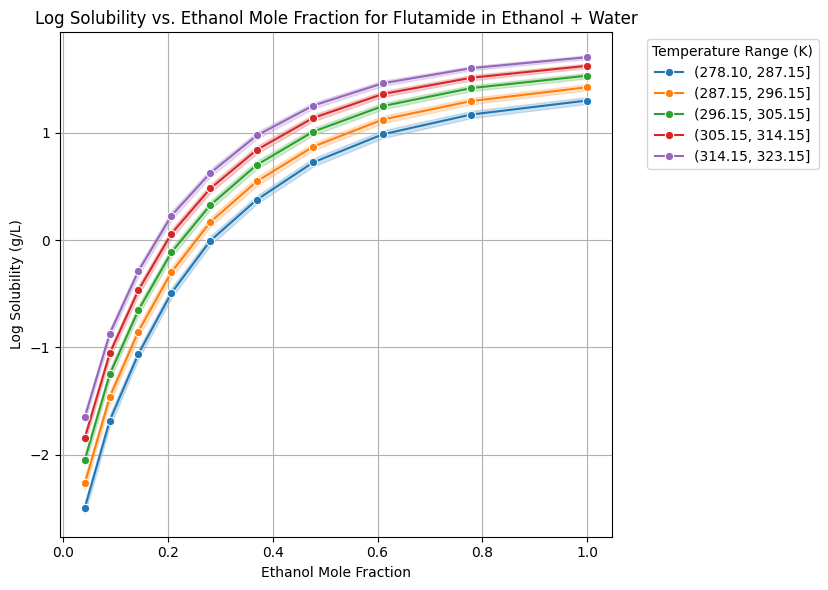

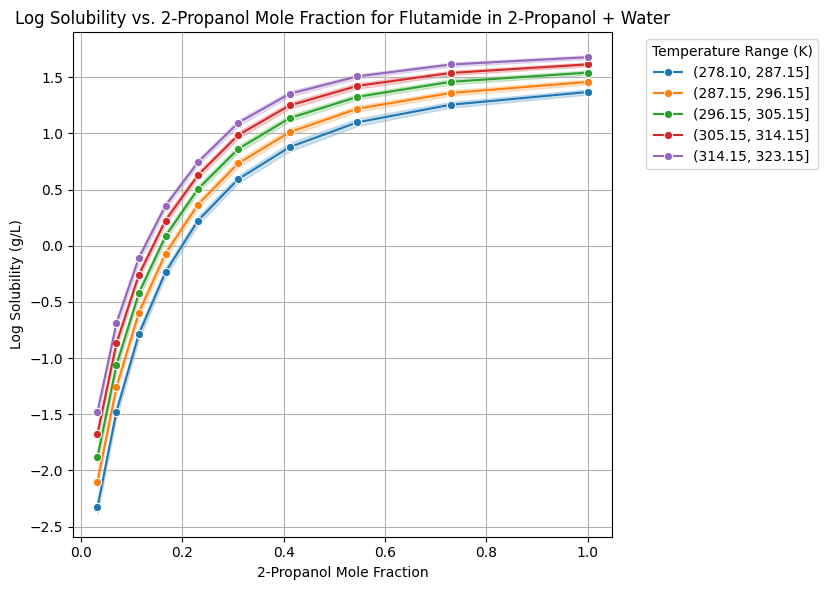

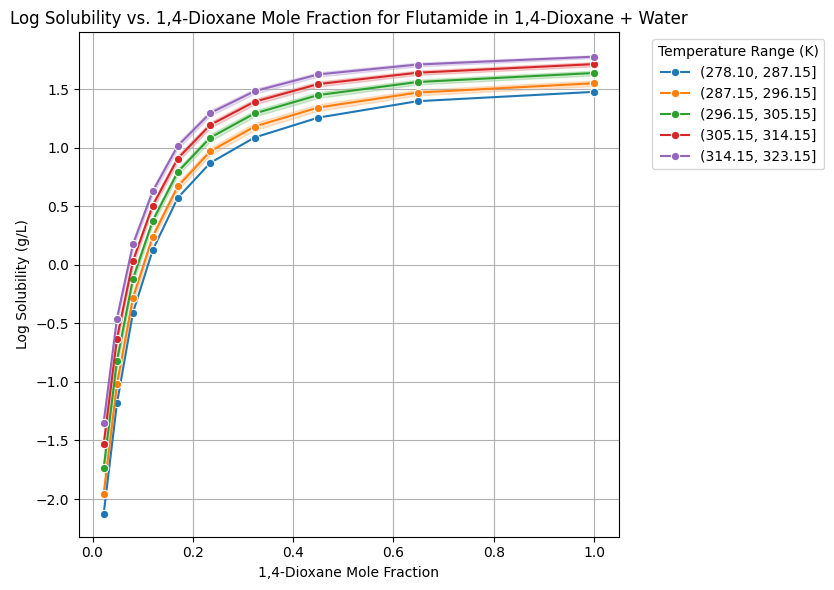

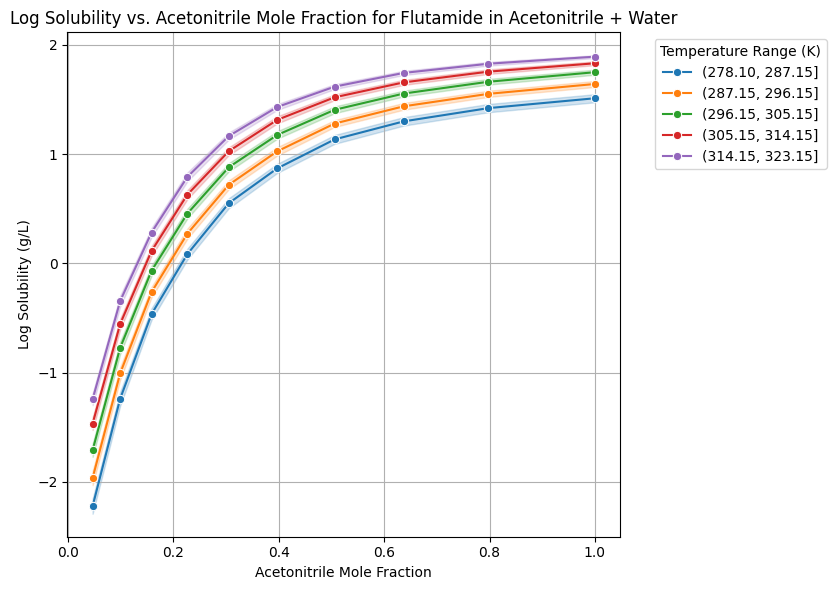

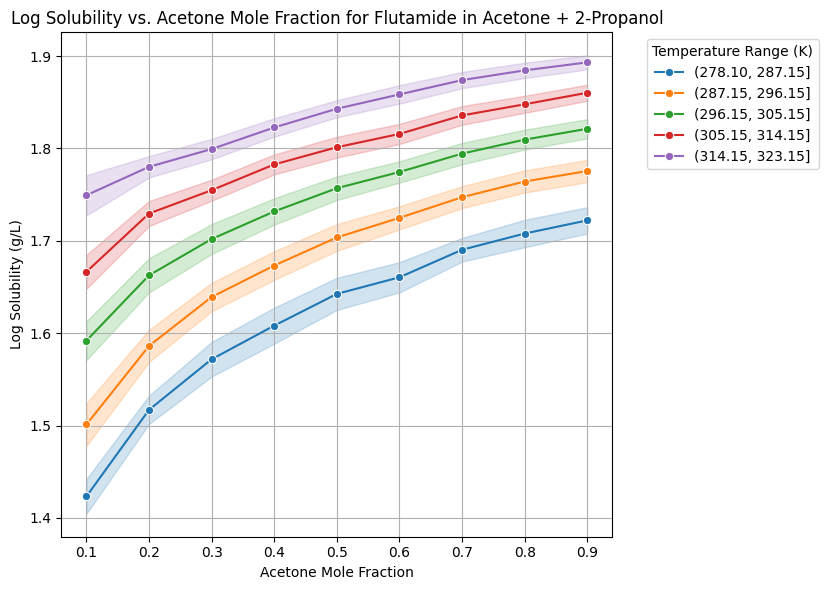

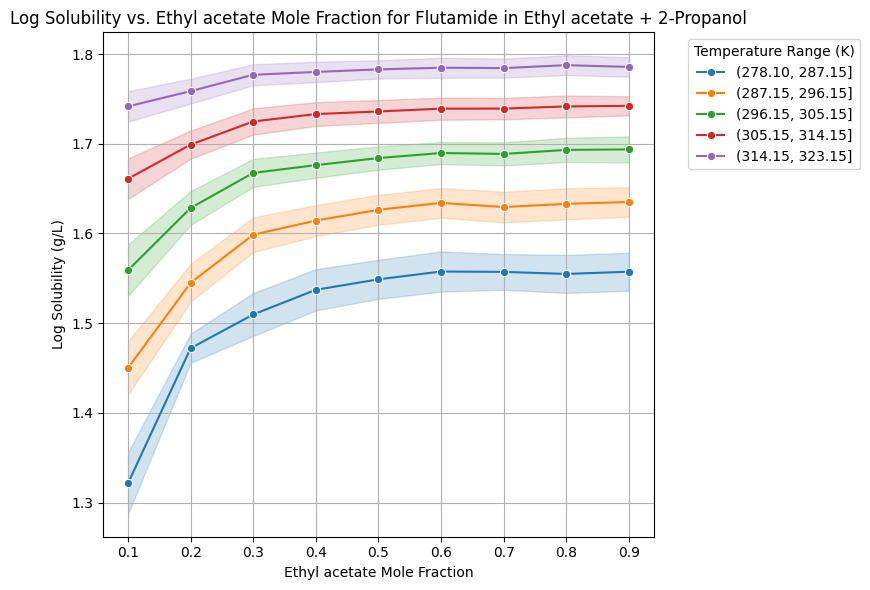

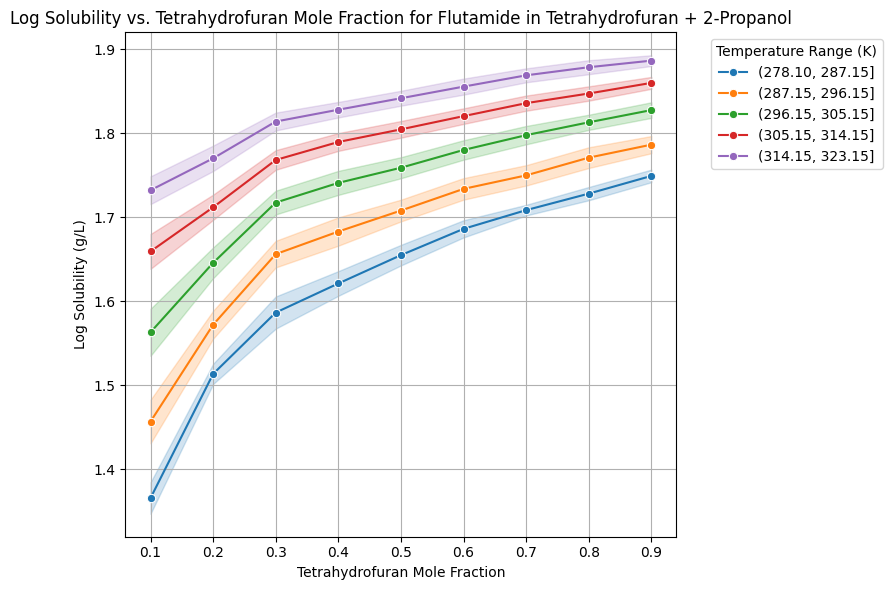

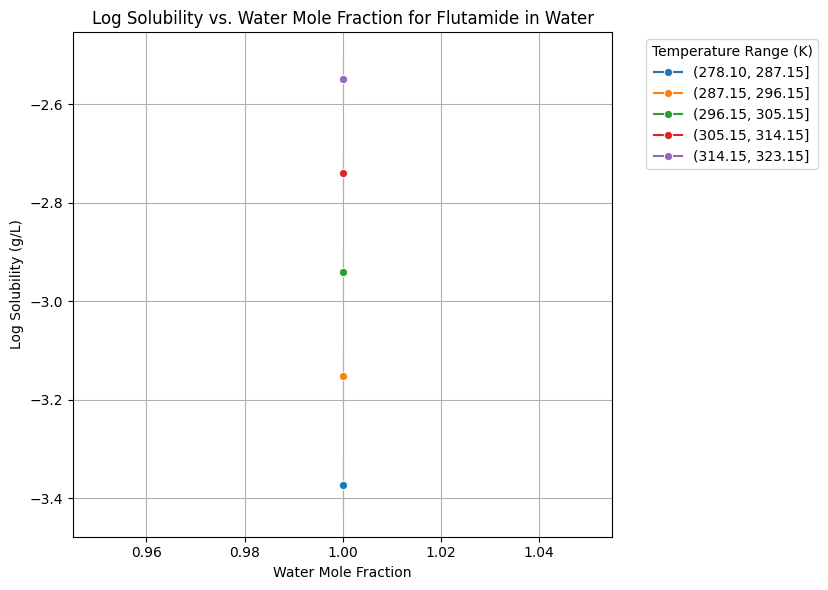

In [ ]:
# Filter the data for drug with cmp_ids_drug as "[49]"
df_49 = df[df['cmp_ids_drug'].astype(str).str.strip() == '[49]'].copy()

# Convert string columns into list columns for df_49
if isinstance(df_49['cmp_ids_solvent'].iloc[0], str):
    df_49['cmp_ids_solvent'] = df_49['cmp_ids_solvent'].apply(ast.literal_eval)
if isinstance(df_49['cmp_mole_fractions_solvent'].iloc[0], str):
    df_49['cmp_mole_fractions_solvent'] = df_49['cmp_mole_fractions_solvent'].apply(ast.literal_eval)

# Apply to create new columns in df_49
if 'Solvent1_id' not in df_49.columns:
    df_49[['Solvent1_id', 'Solvent1_frac']] = df_49.apply(lambda row: pd.Series(extract_solvent_info(row, 0)), axis=1)
if 'Solvent2_id' not in df_49.columns:
    df_49[['Solvent2_id', 'Solvent2_frac']] = df_49.apply(lambda row: pd.Series(extract_solvent_info(row, 1)), axis=1)

# Map solvent IDs to names
if 'id_to_name' not in globals():
    id_to_name = dict(zip(df_compound['compound_id'], df_compound['name']))

# Identify unique solvent combinations for drug 49
df_49['solvent_combination'] = df_49['cmp_ids_solvent'].astype(str)
unique_solvent_combinations = df_49['solvent_combination'].unique()

# Create bins for temperature for coloring the lines
num_temp_bins = 5 # Adjust as needed
df_49['Temperature_bin'] = pd.cut(df_49['Temperature, K'], bins=num_temp_bins, include_lowest=True)

# Format the legend labels to two decimal places
df_49['Temperature_bin'] = df_49['Temperature_bin'].cat.rename_categories([f"({interval.left:.2f}, {interval.right:.2f}]" for interval in df_49['Temperature_bin'].cat.categories])

# Iterate through each unique solvent combination and create a line plot
for solvent_combo_str in unique_solvent_combinations:
    # Filter data for the current solvent combination
    df_combo = df_49[df_49['solvent_combination'] == solvent_combo_str].copy()

    # Check if there is enough data to plot
    if df_combo.empty or df_combo['Solvent1_frac'].isnull().all():
        print(f"Skipping plot for {solvent_combo_str}: Not enough data with Solvent 1 fraction.")
        continue

    # Create the line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_combo, x='Solvent1_frac', y='value', hue='Temperature_bin', marker='o')

    # Create a title that includes the solvent names
    solvent_ids = ast.literal_eval(solvent_combo_str)
    solvent_names = [id_to_name.get(float(id), str(id)) for id in solvent_ids]
    title = f'Log Solubility vs. {id_to_name.get(df_combo["Solvent1_id"].dropna().iloc[0], "Solvent 1")} Mole Fraction for Flutamide in {" + ".join(solvent_names)}'

    plt.title(title)
    plt.xlabel(f'{id_to_name.get(df_combo["Solvent1_id"].dropna().iloc[0], "Solvent 1")} Mole Fraction')
    plt.ylabel('Log Solubility (g/L)')
    plt.grid(True)
    plt.legend(title='Temperature Range (K)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

## 2.7 Bivariate Analysis - Flutamide Log Solubility VS Solvent 2 Mole Fractoins in Different Temperature Ranges

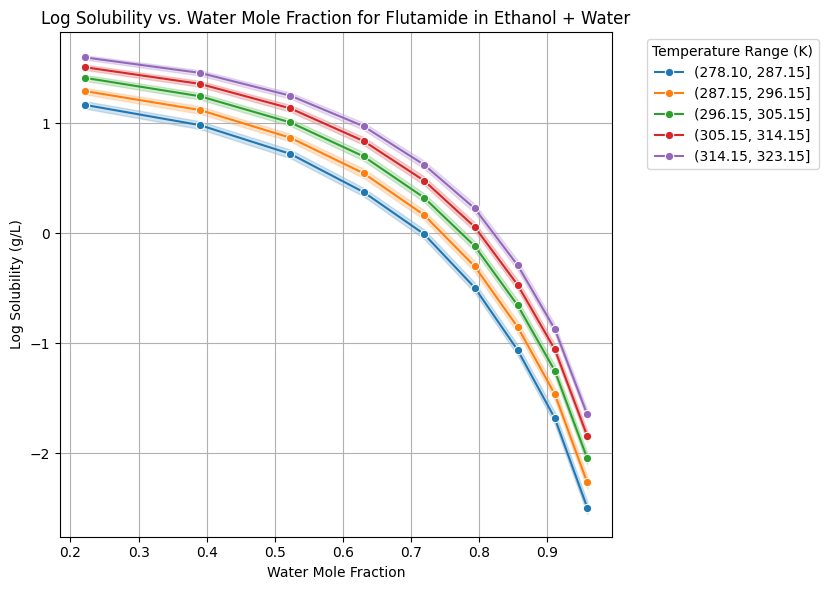

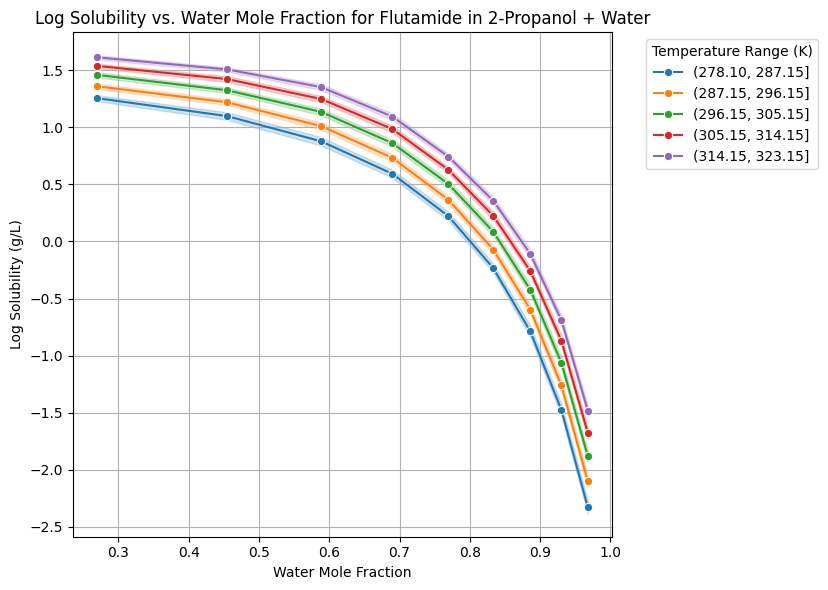

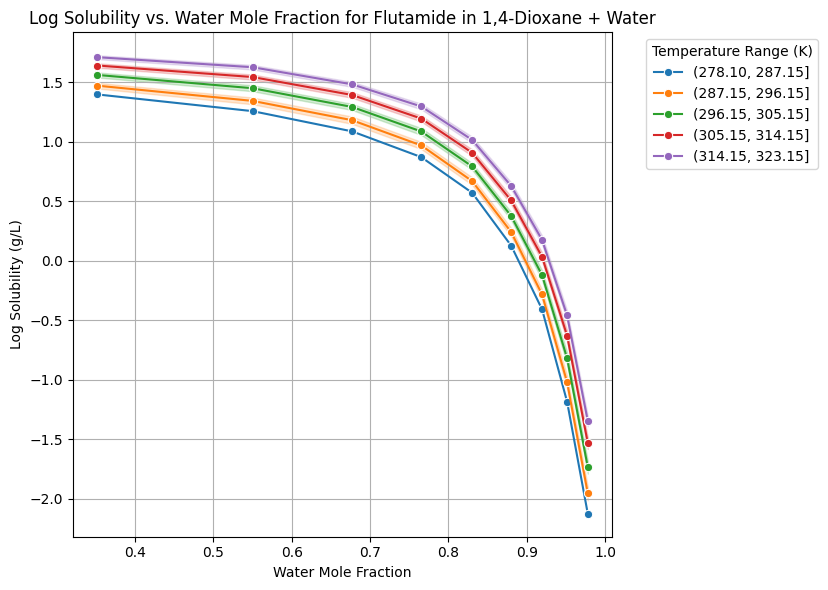

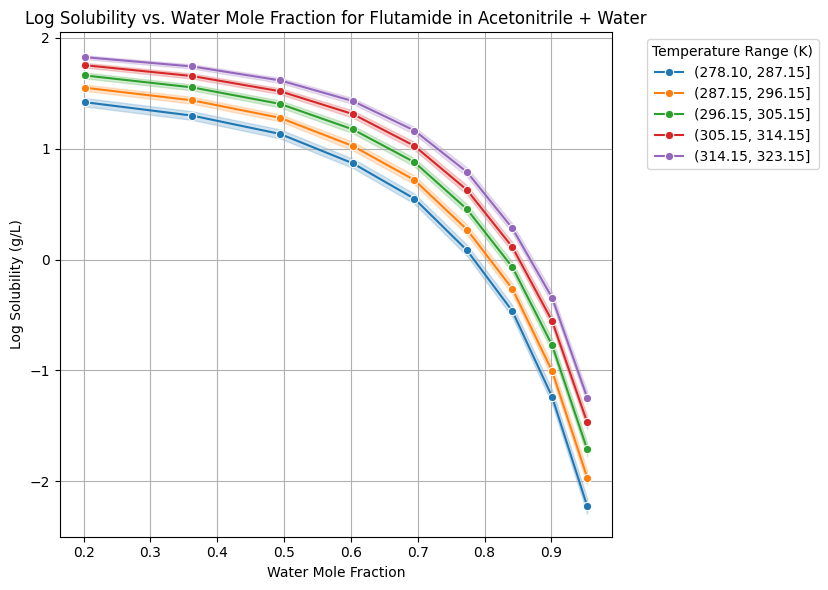

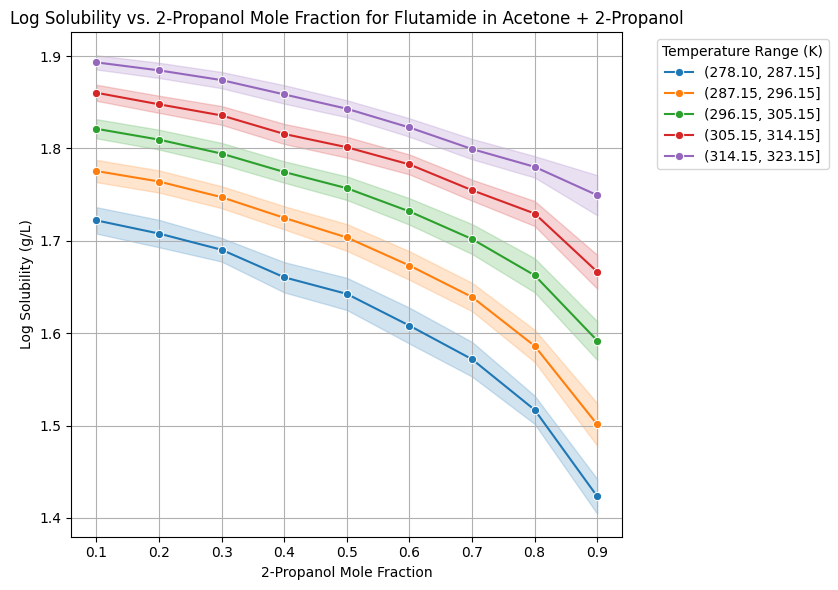

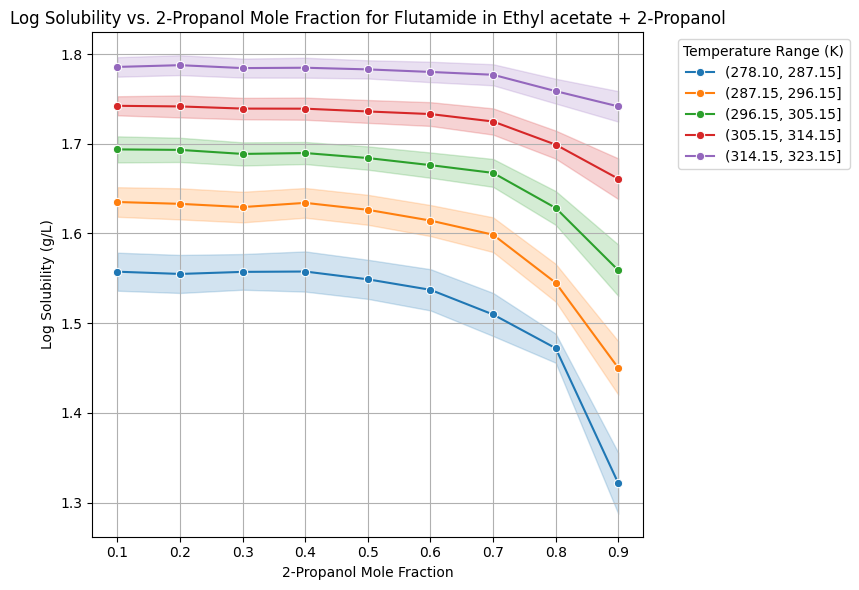

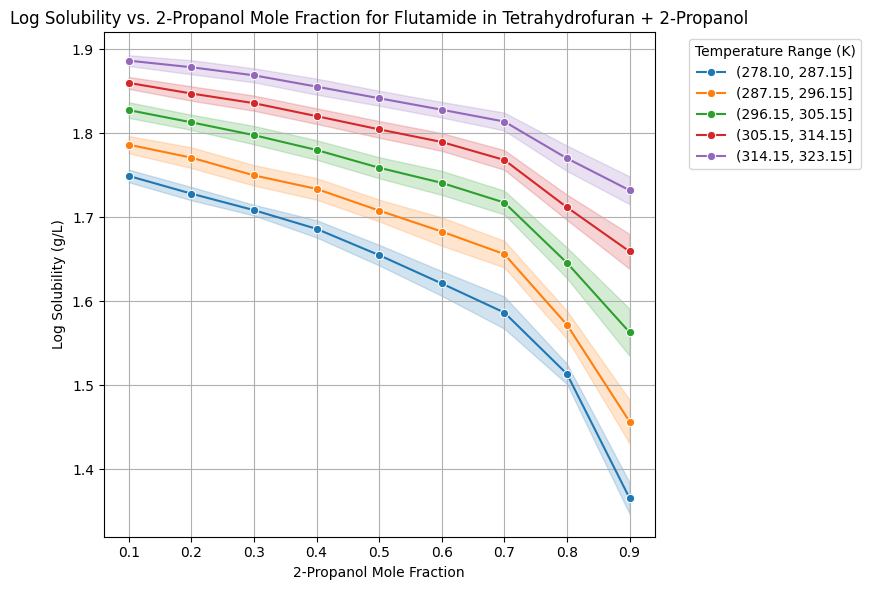

Skipping plot for [129.0]: Not a mixture or not enough data with Solvent 2 fraction.


In [ ]:
# Filter the data for drug with cmp_ids_drug as "[49]" (assuming we continue with drug 49 as in the previous steps)
df_49 = df[df['cmp_ids_drug'].astype(str).str.strip() == '[49]'].copy()

# Convert string columns into list columns for df_49
if isinstance(df_49['cmp_ids_solvent'].iloc[0], str):
    df_49['cmp_ids_solvent'] = df_49['cmp_ids_solvent'].apply(ast.literal_eval)
if isinstance(df_49['cmp_mole_fractions_solvent'].iloc[0], str):
    df_49['cmp_mole_fractions_solvent'] = df_49['cmp_mole_fractions_solvent'].apply(ast.literal_eval)

# Apply to create new columns in df_49
if 'Solvent1_id' not in df_49.columns:
    df_49[['Solvent1_id', 'Solvent1_frac']] = df_49.apply(lambda row: pd.Series(extract_solvent_info(row, 0)), axis=1)
if 'Solvent2_id' not in df_49.columns:
    df_49[['Solvent2_id', 'Solvent2_frac']] = df_49.apply(lambda row: pd.Series(extract_solvent_info(row, 1)), axis=1)

# Map solvent IDs to names
if 'id_to_name' not in globals():
    id_to_name = dict(zip(df_compound['compound_id'], df_compound['name']))

# Identify unique solvent combinations for drug 49
df_49['solvent_combination'] = df_49['cmp_ids_solvent'].astype(str)
unique_solvent_combinations = df_49['solvent_combination'].unique()

# Create bins for temperature for coloring the lines
num_temp_bins = 5 # Adjust as needed
df_49['Temperature_bin'] = pd.cut(df_49['Temperature, K'], bins=num_temp_bins, include_lowest=True)

# Format the legend labels to two decimal places
df_49['Temperature_bin'] = df_49['Temperature_bin'].cat.rename_categories([f"({interval.left:.2f}, {interval.right:.2f}]" for interval in df_49['Temperature_bin'].cat.categories])


# Iterate through each unique solvent combination and create a line plot
for solvent_combo_str in unique_solvent_combinations:
    # Filter data for the current solvent combination
    df_combo = df_49[df_49['solvent_combination'] == solvent_combo_str].copy()

    # Check if the combination has a second solvent and enough data to plot
    if df_combo.empty or df_combo['Solvent2_frac'].isnull().all() or df_combo['Solvent2_id'].isnull().all():
        print(f"Skipping plot for {solvent_combo_str}: Not a mixture or not enough data with Solvent 2 fraction.")
        continue

    # Create the line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_combo, x='Solvent2_frac', y='value', hue='Temperature_bin', marker='o')

    # Create a title that includes the solvent names
    solvent_ids = ast.literal_eval(solvent_combo_str)
    solvent_names = [id_to_name.get(float(id), str(id)) for id in solvent_ids]
    # Get the name of Solvent 2 for the x-axis label
    solvent2_id_in_plot = df_combo['Solvent2_id'].dropna().iloc[0] if not df_combo['Solvent2_id'].dropna().empty else None
    solvent2_name_in_plot = id_to_name.get(solvent2_id_in_plot, str(int(solvent2_id_in_plot))) if solvent2_id_in_plot is not None else 'Solvent 2'

    title = f'Log Solubility vs. {solvent2_name_in_plot} Mole Fraction for Flutamide in {" + ".join(solvent_names)}'

    plt.title(title)
    plt.xlabel(f'{solvent2_name_in_plot} Mole Fraction')
    plt.ylabel('Log Solubility (g/L)')
    plt.grid(True)
    plt.legend(title='Temperature Range (K)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

## 2.8 Bivariate Analysis - Flutamide Log Solubility VS Temperature for Different Solvent Combination

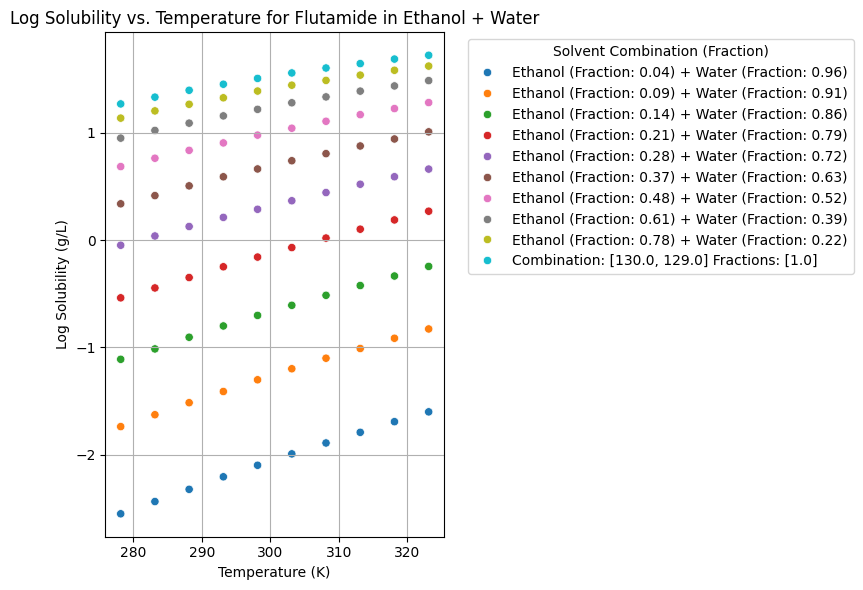

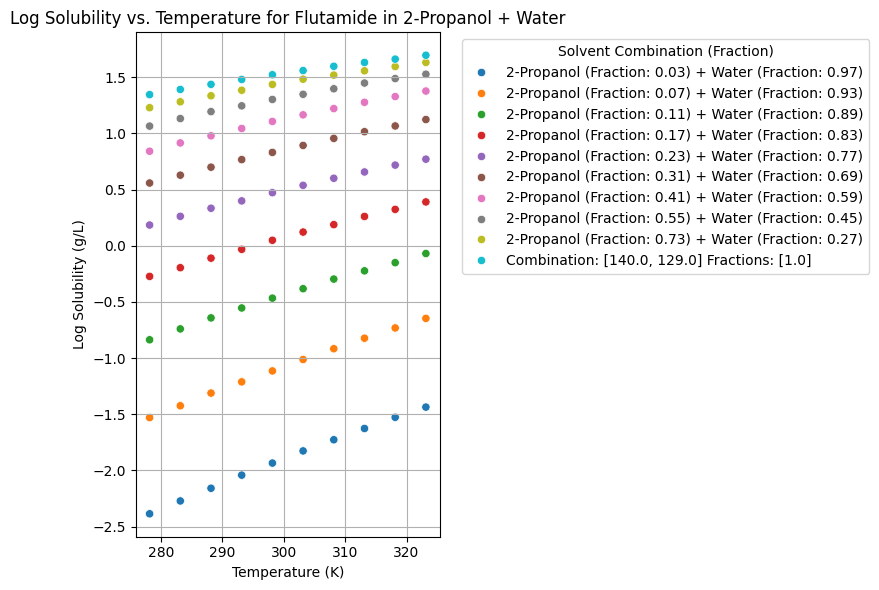

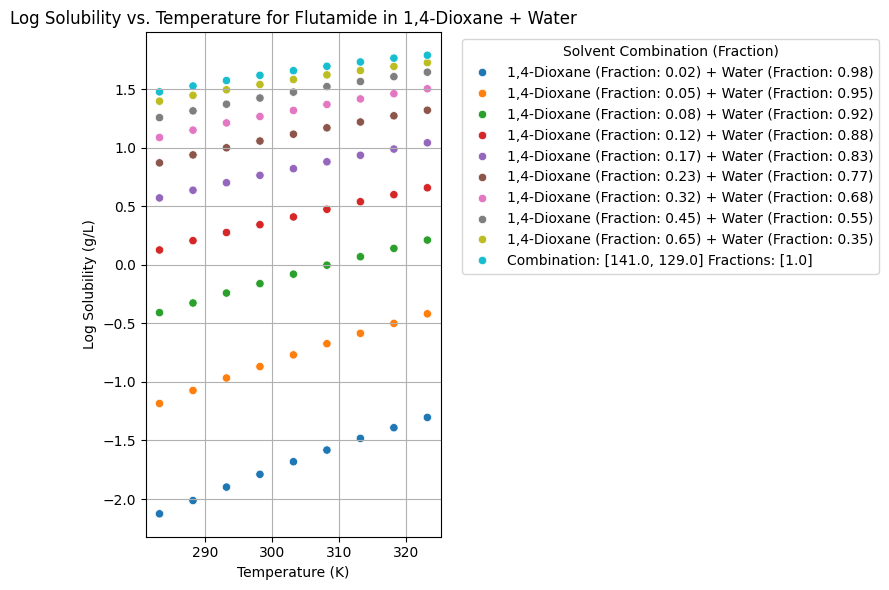

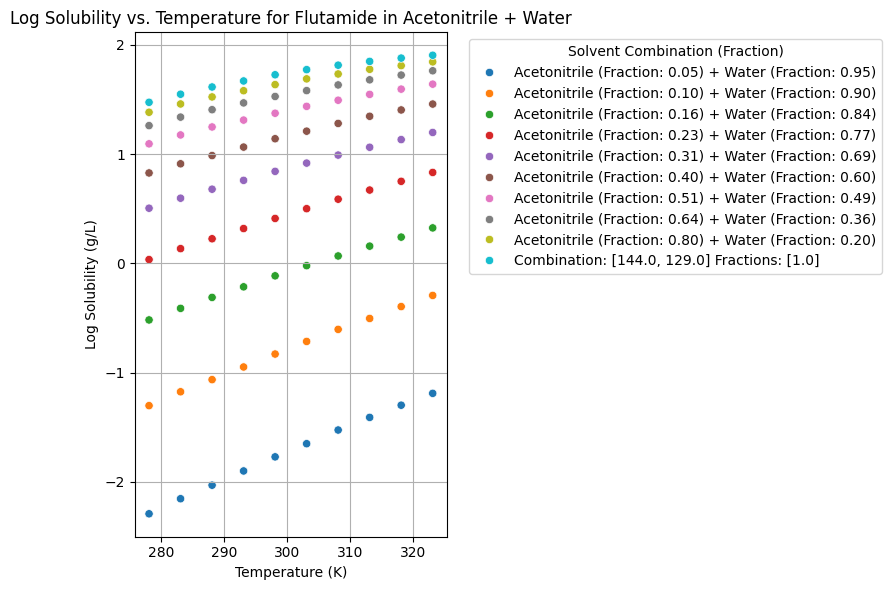

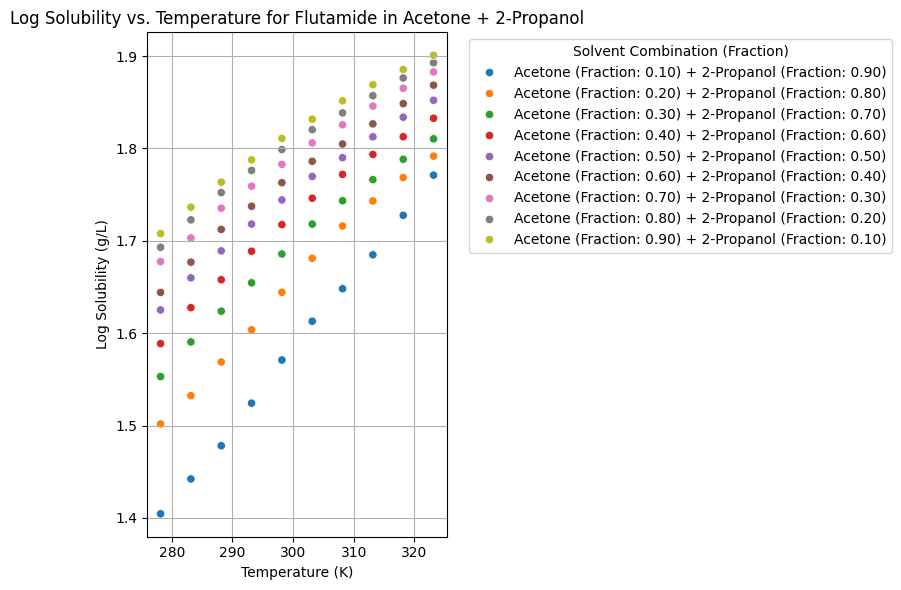

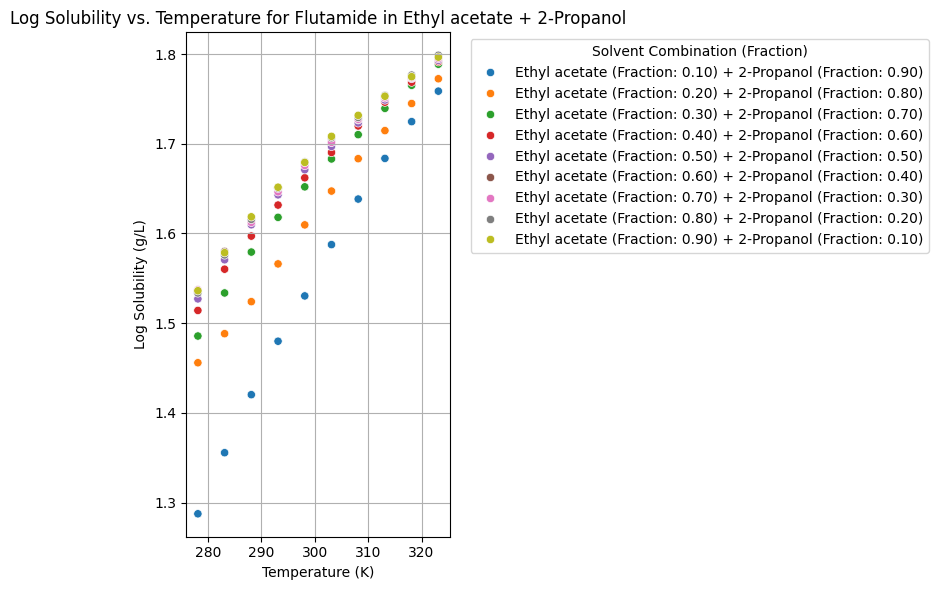

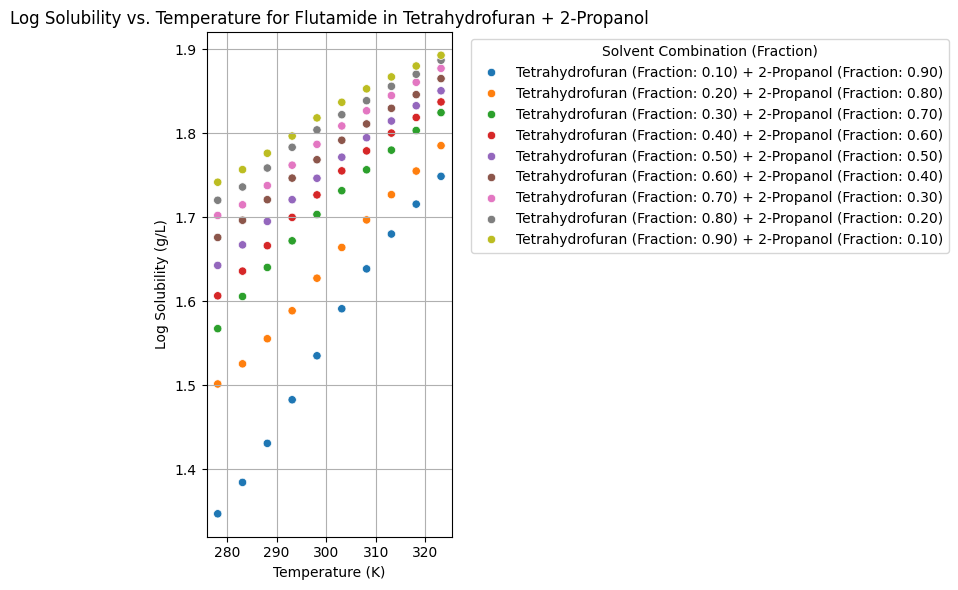

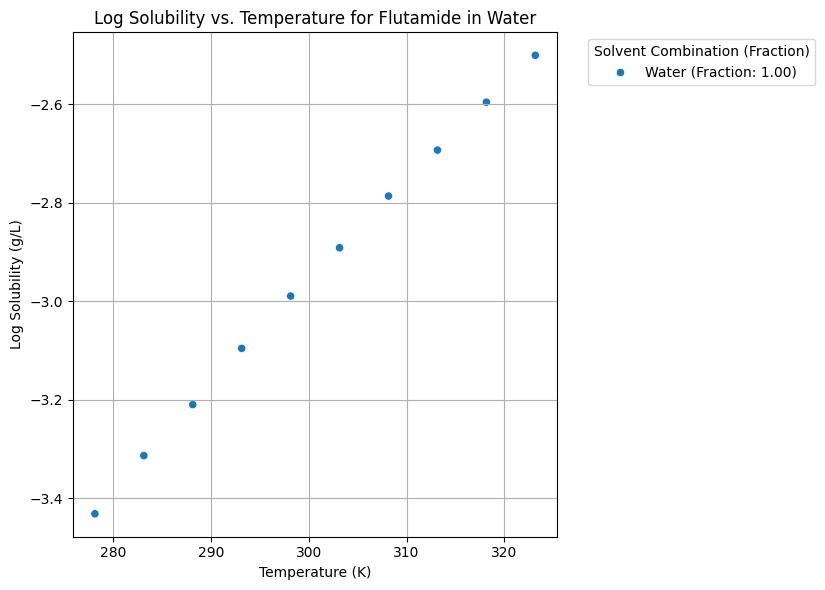

In [ ]:
# Filter the data for drug with cmp_ids_drug as "[49]" (Flutamide)
df_49 = df[df['cmp_ids_drug'].astype(str).str.strip() == '[49]'].copy()

# Convert string columns into list columns for df_49 if they are still strings
if isinstance(df_49['cmp_ids_solvent'].iloc[0], str):
    df_49['cmp_ids_solvent'] = df_49['cmp_ids_solvent'].apply(ast.literal_eval)
if isinstance(df_49['cmp_mole_fractions_solvent'].iloc[0], str):
    df_49['cmp_mole_fractions_solvent'] = df_49['cmp_mole_fractions_solvent'].apply(ast.literal_eval)

# Re-apply solvent info extraction in case the original df was modified later
def extract_solvent_info(row, index):
    try:
        return row['cmp_ids_solvent'][index], row['cmp_mole_fractions_solvent'][index]
    except IndexError:
        return None, None

if 'Solvent1_id' not in df_49.columns or 'Solvent2_id' not in df_49.columns:
    df_49[['Solvent1_id', 'Solvent1_frac']] = df_49.apply(lambda row: pd.Series(extract_solvent_info(row, 0)), axis=1)
    df_49[['Solvent2_id', 'Solvent2_frac']] = df_49.apply(lambda row: pd.Series(extract_solvent_info(row, 1)), axis=1)

# Map solvent IDs to names if the mapping is not already in the environment
if 'id_to_name' not in globals():
    id_to_name = dict(zip(df_compound['compound_id'], df_compound['name']))

# Identify unique solvent combinations for drug 49 and add as a column
df_49['solvent_combination'] = df_49['cmp_ids_solvent'].astype(str)

# Create a column for the base solvent combination names (without fractions) for grouping
df_49['solvent_combination_base_name'] = df_49['cmp_ids_solvent'].apply(lambda x: " + ".join([id_to_name.get(float(id), str(id)) for id in x]))

# Create a new column that represents the solvent combination names and fractions for coloring
def create_solvent_fraction_label(row):
    solvent_ids = row['cmp_ids_solvent'] # Use the list directly
    solvent_names = [id_to_name.get(float(id), str(id)) for id in solvent_ids]
    solvent_fractions = row['cmp_mole_fractions_solvent']

    try:
        if len(solvent_names) == 1 and len(solvent_fractions) == 1:
            return f'{solvent_names[0]} (Fraction: {solvent_fractions[0]:.2f})'
        elif len(solvent_names) == 2 and len(solvent_fractions) == 2:
            return f'{solvent_names[0]} (Fraction: {solvent_fractions[0]:.2f}) + {solvent_names[1]} (Fraction: {solvent_fractions[1]:.2f})'
        else:
            return f"Combination: {str(solvent_ids)} Fractions: {str(solvent_fractions)}" # More informative fallback
    except IndexError:
        return f"Error processing Combination: {str(solvent_ids)} Fractions: {str(solvent_fractions)}" # Error handling for index out of range


df_49['solvent_fraction_label'] = df_49.apply(create_solvent_fraction_label, axis=1)

# Identify unique base solvent combinations for iterating
unique_base_solvent_combinations = df_49['solvent_combination_base_name'].unique()

# Iterate through each unique base solvent combination and create a single scatter plot
for base_solvent_name in unique_base_solvent_combinations:
    # Filter data for the current base solvent combination
    df_combo_base = df_49[df_49['solvent_combination_base_name'] == base_solvent_name].copy()

    # Create a scatter plot, using the solvent_fraction_label for hue
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_combo_base, x='Temperature, K', y='value', hue='solvent_fraction_label', legend='full')

    title = f'Log Solubility vs. Temperature for Flutamide in {base_solvent_name}'

    plt.title(title)
    plt.xlabel('Temperature (K)')
    plt.ylabel('Log Solubility (g/L)')
    plt.grid(True)
    # Position the legend outside the plot
    plt.legend(title='Solvent Combination (Fraction)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for the legend
    plt.show()

In [ ]:
df_49.columns

Index(['value', 'Temperature, K', 'property', 'unit', 'cmp_ids_solvent',
       'cmp_mole_fractions_solvent', 'cmp_ids_drug', 'cmp_mole_fractions_drug',
       'Solvent1_id', 'Solvent1_frac', 'Solvent2_id', 'Solvent2_frac',
       'Solvent1_name', 'Solvent2_name', 'drug_mol', 'Solvent1_smiles',
       'Solvent2_smiles', 'Solvent1_mol', 'Solvent2_mol', 'drug_HBA',
       'drug_HBD', 'drug_logP', 'drug_TPSA', 'Solvent1_HBA', 'Solvent1_HBD',
       'Solvent1_logP', 'Solvent1_TPSA', 'Solvent2_HBA', 'Solvent2_HBD',
       'Solvent2_logP', 'Solvent2_TPSA', 'Solvent1_Dielectric', 'Solvent1_δD',
       'Solvent1_δP', 'Solvent1_δH', 'Solvent2_Dielectric', 'Solvent2_δD',
       'Solvent2_δP', 'Solvent2_δH', 'drug_δD', 'drug_δP', 'drug_δH',
       'Solvent1_Solvent2_Ra', 'drug_Dielectric', 'drug_fp', 'Solvent1_fp',
       'Solvent2_fp', 'ILR_coordinate', 'weighted_HBA', 'weighted_HBD',
       'weighted_logP', 'weighted_TPSA', 'weighted_Dielectric', 'weighted_fp',
       'Temperature_bin', 'Solubi